In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Vanishing and Exploding gradients problem

In [2]:
def logit(z):
    return(1 / (1 + np.exp(-z)))

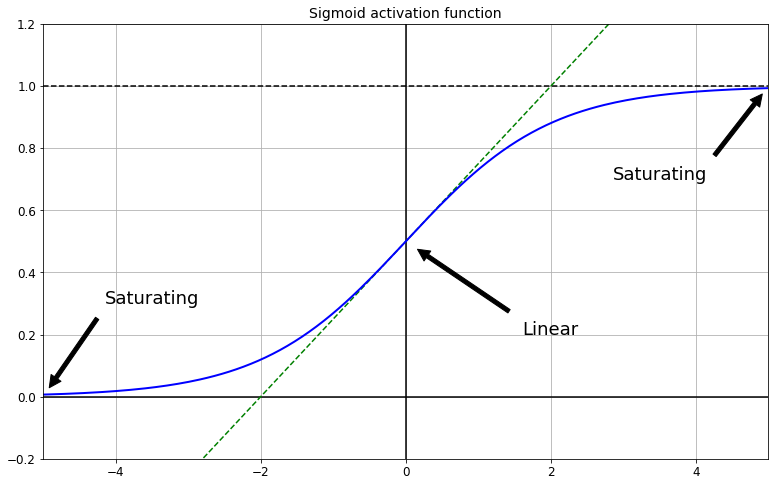

In [3]:
z = np.linspace(-5,5,200)
plt.figure(figsize=(13,8))

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')

plt.plot(z,logit(z),"b-",linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center",size=18)
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center",size=18)
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center",size=18)
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### Xavier and He initlization

In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300

X = tf.placeholder(tf.float32,shape =(None,n_inputs),name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [7]:
he_init

In [8]:
hidden1

<tf.Tensor 'hidden1/Relu:0' shape=(?, 300) dtype=float32>

## Nonsaturing activation functions
### Leaky ReLU

In [9]:
def leaky_relu(z, alpha = 0.01):
    return(np.maximum(alpha*z,z))

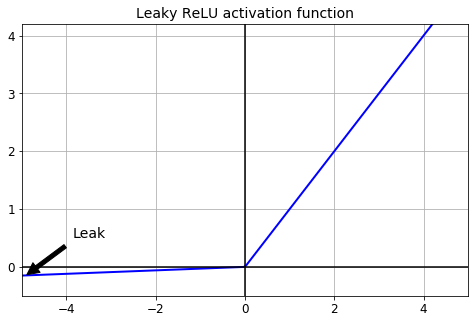

In [11]:
plt.figure(figsize=(8,5))
plt.plot(z, leaky_relu(z, 0.03), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

### Implementing leak relu in tensorflow

In [12]:
reset_graph()
X = tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")

In [13]:
def leaky_relu(z,name=None):
    return(tf.maximum(0.01*z,z,name=name))

hidden1 = tf.layers.dense(X,n_hidden1,activation=leaky_relu,name='hidden1')

In [14]:
hidden1

<tf.Tensor 'hidden1/Maximum:0' shape=(?, 300) dtype=float32>

Lets train a neural network on MNIST using the leakyrelu

In [15]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")
y = tf.placeholder(tf.int32, shape=(None),name= "y")

In [16]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [17]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy,name='loss')

In [18]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

In [20]:
training_op

<tf.Operation 'train/GradientDescent' type=NoOp>

In [21]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Lets load in the data and define some functions

In [22]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [23]:
tf.keras.datasets.mnist.load_data()[1][1]

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [24]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
    

In [25]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [26]:
loss_summary = tf.summary.scalar('loss', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [30]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            summary_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
            file_writer.add_summary(summary_str, epoch)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.48 Validation accuracy: 0.4956
5 Batch accuracy: 0.838 Validation accuracy: 0.8346
10 Batch accuracy: 0.875 Validation accuracy: 0.8806
15 Batch accuracy: 0.915 Validation accuracy: 0.8982
20 Batch accuracy: 0.901 Validation accuracy: 0.9068
25 Batch accuracy: 0.902 Validation accuracy: 0.9128
30 Batch accuracy: 0.914 Validation accuracy: 0.9174
35 Batch accuracy: 0.914 Validation accuracy: 0.9216
40 Batch accuracy: 0.914 Validation accuracy: 0.926
45 Batch accuracy: 0.932 Validation accuracy: 0.9282
50 Batch accuracy: 0.914 Validation accuracy: 0.931
55 Batch accuracy: 0.929 Validation accuracy: 0.9326
60 Batch accuracy: 0.937 Validation accuracy: 0.935
65 Batch accuracy: 0.932 Validation accuracy: 0.9364
70 Batch accuracy: 0.935 Validation accuracy: 0.9376
75 Batch accuracy: 0.935 Validation accuracy: 0.9388
80 Batch accuracy: 0.923 Validation accuracy: 0.9398
85 Batch accuracy: 0.939 Validation accuracy: 0.9414
90 Batch accuracy: 0.947 Validation accuracy: 0.9426

## ELU

In [31]:
def elu(z,alpha=1):
    return(np.where(z<0,alpha*(np.exp(z)-1),z))

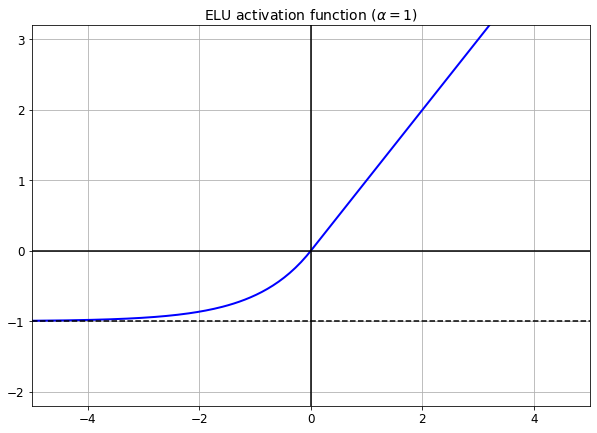

In [32]:
plt.figure(figsize=(10,7))
plt.plot(z,elu(z),"b-",linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

In [33]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

In [34]:
hidden1

<tf.Tensor 'hidden1/Elu:0' shape=(?, 300) dtype=float32>

In [35]:
X

<tf.Tensor 'X:0' shape=(?, 784) dtype=float32>

## SELU, scaled exponential units
* By Klambauer et al
* During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize
* the output of each layer will tend to preserver the mean and variance during training, which solves the vanishing/exploding gradient problem
* outperforms other activation functions
* the function is easily broken and difficult to implement regularization
* it works quite well with sequential CNN's
* if normlization is broken, SELU will not necessarily outperform other functions

\begin{align*}
selu(x) = \lambda
\begin{cases}
x
\quad
\text{if}
\quad x > 0 \\
\alpha e^x
\quad
\text{if}
\quad
x << 0
\end{cases}
\end{align*}

In [36]:
from scipy.special import erfc

#alphda and scale to sel normalize with mean and st dev 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)


In [37]:
alpha_0_1

1.6732632423543778

In [38]:
scale_0_1

1.0507009873554805

In [39]:
erfc(4)

1.541725790028002e-08

In [40]:
def selu(z,scale=scale_0_1,alpha=alpha_0_1):
    return(scale*elu(z,alpha))

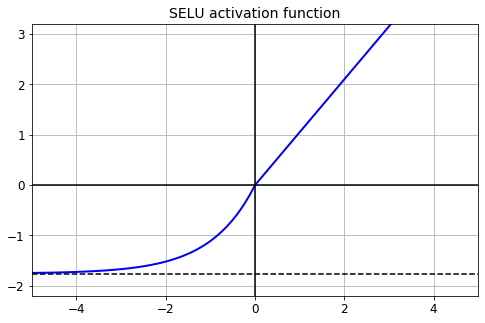

In [41]:
plt.figure(figsize=(8,5))
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])


plt.show()

For all x less than 0, it has the shape e^x, but flipped

The SELU hyperparameters (scale and alpha) are tuned in such a way that the mean oupt of each nueron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1000 layers deep neural network preservers roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [42]:
np.random.seed(56784)
Z = np.random.normal(size=(500,100))
for layer in range(1000):
    W = np.random.normal(size=(100,100),scale = np.sqrt(1/100)) #lecun initialzation over 100 nueron layer
    Z = selu(np.dot(Z,W))
    means = np.mean(Z,axis=0).mean()
    stds = np.std(Z,axis=0).mean()
    if layer % 50 == 0:
        print('Layer {}: mean {:2f}, std deviation {:.2f}'.format(layer,means,stds))

Layer 0: mean 0.003619, std deviation 1.01
Layer 50: mean -0.000275, std deviation 0.97
Layer 100: mean -0.009258, std deviation 0.91
Layer 150: mean -0.013290, std deviation 0.93
Layer 200: mean -0.001869, std deviation 0.88
Layer 250: mean 0.043744, std deviation 0.87
Layer 300: mean 0.017311, std deviation 0.86
Layer 350: mean 0.041500, std deviation 0.96
Layer 400: mean -0.012337, std deviation 0.86
Layer 450: mean 0.014573, std deviation 0.88
Layer 500: mean 0.004564, std deviation 0.93
Layer 550: mean -0.038700, std deviation 0.91
Layer 600: mean 0.017596, std deviation 0.88
Layer 650: mean 0.058942, std deviation 1.01
Layer 700: mean -0.012028, std deviation 0.92
Layer 750: mean -0.039358, std deviation 0.94
Layer 800: mean 0.030063, std deviation 0.92
Layer 850: mean -0.018686, std deviation 0.91
Layer 900: mean 0.012818, std deviation 0.88
Layer 950: mean -0.016715, std deviation 0.95


In [43]:
Z.shape

(500, 100)

In [44]:
W.shape

(100, 100)

In [45]:
selu(np.dot(Z,W)).shape

(500, 100)

In [46]:
def selu(z,scale=alpha_0_1,alpha=scale_0_1):
    return(scale*tf.where(z>=0,z,alpha*tf.nn.elu(z)))

Note, the SELU activation function cannot be used along the regular Dropout (this would cancel the SELU activation function's self normalizing property). Fortunately, there is a drpout variant called alpha drpopout propes in the paper about SELU

Lets creatue a neurla network for MNSIT using the SELU activation function:

In [105]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 400
n_hidden2 = 200
n_outputs = 10

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")
y = tf.placeholder(tf.int32,shape=(None),name='y')

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy,name='loss')
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 50
batch_size = 200

Now lets train it, and don't forget to scale the inputs to mean 0 and standard deviation 1

In [118]:
means = X_train.mean(axis =0, keepdims=True)
stds = X_train.std(axis=0,keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.945 Validation accuracy: 0.91
5 Batch accuracy: 0.945 Validation accuracy: 0.9526
10 Batch accuracy: 0.975 Validation accuracy: 0.9602
15 Batch accuracy: 0.975 Validation accuracy: 0.9624
20 Batch accuracy: 0.995 Validation accuracy: 0.9658
25 Batch accuracy: 0.995 Validation accuracy: 0.965
30 Batch accuracy: 0.995 Validation accuracy: 0.9654
35 Batch accuracy: 0.995 Validation accuracy: 0.9662
40 Batch accuracy: 1.0 Validation accuracy: 0.9668
45 Batch accuracy: 0.995 Validation accuracy: 0.9666


In [47]:
X_train.mean(axis=0,keepdims=True).shape

(1, 784)

In [48]:
X_train.shape

(55000, 784)

In [49]:
1e-7

1e-07

## Batch normalization

Instead of using the batch_norm() function as a regulairze paramters to the fully_connected() function, we not use batch normizlation() and we explicitly create a disttinc layer. There parameters are a bit different in particular

* decay is reanmed ot momentum
* is training is renamed to trianing

not that in order to run batch norm just before each hidden layers activation function, we apply the ELU activation function manually, right after the batch norm layer

We compare notation using partial and not using partial

In [50]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


In [51]:
reset_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name= "X")
training = tf.placeholder_with_default(False, shape=(),name='training')

To avoid repeating, we use python's partial function

In [52]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [55]:
tf.layers.batch_normalization

<function tensorflow.python.layers.normalization.batch_normalization(inputs, axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer=<tensorflow.python.ops.init_ops.Zeros object at 0x63e9dbe10>, gamma_initializer=<tensorflow.python.ops.init_ops.Ones object at 0x63e9dbe48>, moving_mean_initializer=<tensorflow.python.ops.init_ops.Zeros object at 0x63e9dbeb8>, moving_variance_initializer=<tensorflow.python.ops.init_ops.Ones object at 0x63e9dbf28>, beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None, training=False, trainable=True, name=None, reuse=None, renorm=False, renorm_clipping=None, renorm_momentum=0.99, fused=None, virtual_batch_size=None, adjustment=None)>

Try implementing a neural net for MNIST, using the activation ELU function and Batch Normalization at each layer"

In [60]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32,shape=(None, n_inputs),name="X")
y = tf.placeholder(tf.int32,shape=(None),name="y")
training = tf.placeholder_with_default(False, shape=(),name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()
    
    my_batch_norm_layer = partial(tf.layers.batch_normalization,
                                 training=training,
                                 momentum=batch_norm_momentum)
    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)
    
    hidden1 = my_dense_layer(X,n_hidden1,name='hidden1')
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1,n_hidden2,name='hidden2')
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2,n_outputs,name='outputs')
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

since we are sing batch.normalization instead of contrb, we need to explictly run the extra update opertiaons by batch norm

In [61]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
loss_summary = tf.summary.scalar('Loss', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [62]:
n_epochs = 50
batch_size = 200

In [63]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            summary_str =loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
            file_writer.add_summary(summary_str, epoch)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8952
1 Validation accuracy: 0.9202
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.9422
4 Validation accuracy: 0.9468
5 Validation accuracy: 0.954
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.96
8 Validation accuracy: 0.962
9 Validation accuracy: 0.9638
10 Validation accuracy: 0.9662
11 Validation accuracy: 0.9682
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9726
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9742
20 Validation accuracy: 0.9738
21 Validation accuracy: 0.9746
22 Validation accuracy: 0.9742
23 Validation accuracy: 0.9758
24 Validation accuracy: 0.9756
25 Validation accuracy: 0.9752
26 Validation accuracy: 0.9748
27 Validation accuracy: 0.9758
28 Validation accuracy: 0.976
29 Validation accuracy: 0.9772
30 Validation accuracy: 0.9768
31 Validation accuracy: 0.9766
32 Validation accuracy:

in this batch normilzation helped me out!

Most of the time, batch norm and elu are most likely to have an effect in deeper networks.

We could have alos implement the training operation this way:

In [64]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)

In this way, you would just have to evaluate the trainiing_op during training. tensorflow would automatically run the update operations as well:

Notice that the list of trainiable variables is hsorter than the list of all global variables. This is because the moving averages are non-trainable variables. if you want to re sue a pretraiend nueral network (see below) you must not forther these non-trainable variables

In [66]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [138]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## Gradient Clipping

Lets create a simple neural net for MNSIT and add gradient clipping. The first part is the same as earleir (except we added a few more layers to demonstrate reusing pretrained models!

In [146]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32,shape=(None, n_inputs),name="X")
y = tf.placeholder(tf.int32,shape=(None),name='y')

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy,name='loss')


In [147]:
learning_rate = 0.01

Now we apply gradient cliping. For this we need to get the gradients, use the clipp_by_value() then apply them

In [148]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [149]:
#creat the usual parts of the subgraph
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32),name='accuracy')

In [150]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [151]:
n_epochs = 50
batch_size = 200

In [152]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.2876
1 Validation accuracy: 0.7944
2 Validation accuracy: 0.8796
3 Validation accuracy: 0.9058
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9218
6 Validation accuracy: 0.9292
7 Validation accuracy: 0.9356
8 Validation accuracy: 0.9378
9 Validation accuracy: 0.9416
10 Validation accuracy: 0.9456
11 Validation accuracy: 0.947
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9532
14 Validation accuracy: 0.9564
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.959
18 Validation accuracy: 0.9624
19 Validation accuracy: 0.9614
20 Validation accuracy: 0.9634
21 Validation accuracy: 0.9646
22 Validation accuracy: 0.9648
23 Validation accuracy: 0.9646
24 Validation accuracy: 0.9666
25 Validation accuracy: 0.9672
26 Validation accuracy: 0.9682
27 Validation accuracy: 0.9664
28 Validation accuracy: 0.966
29 Validation accuracy: 0.9714
30 Validation accuracy: 0.9672
31 Validation accuracy: 0.9704
32 Validation accurac

## Reusing pretrained Layers
### Reusing a TensforFlow Model

First you need to load the graph's structue. The import_meta_graph() functions does just that, loading the graphs operations into the default graph, and returning a Saver that you can use to restore the model' state. Note that by default, a Saver saves the strucutre of the graph into a .meta file so thatss the file you shoud load!

In [154]:
reset_graph()

In [163]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [164]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [166]:
from __future__ import absolute_import, division, print_function, unicode_literals

# This module defines the show_graph() function to visualize a TensorFlow graph within Jupyter.

# As far as I can tell, this code was originally written by Alex Mordvintsev at:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

# The original code only worked on Chrome (because of the use of <link rel="import"...>, but the version below
# uses Polyfill (copied from this StackOverflow answer: https://stackoverflow.com/a/41463991/38626)
# so that it can work on other browsers as well.

import numpy as np
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [180]:
show_graph(tf.get_default_graph())

In [168]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [173]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [174]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

In [175]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [176]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9758
1 Validation accuracy: 0.9744
2 Validation accuracy: 0.974
3 Validation accuracy: 0.9764
4 Validation accuracy: 0.9732
5 Validation accuracy: 0.976
6 Validation accuracy: 0.975
7 Validation accuracy: 0.9764
8 Validation accuracy: 0.9764
9 Validation accuracy: 0.9758
10 Validation accuracy: 0.9748
11 Validation accuracy: 0.9774
12 Validation accuracy: 0.9732
13 Validation accuracy: 0.9742
14 Validation accuracy: 0.9762
15 Validation accuracy: 0.976
16 Validation accuracy: 0.9756
17 Validation accuracy: 0.9762
18 Validation accuracy: 0.976
19 Validation accuracy: 0.9772
20 Validation accuracy: 0.9756
21 Validation accuracy: 0.976
22 Validation accuracy: 0.977
23 Validation accuracy: 0.9756
24 Validation accuracy: 0.9754
25 Validation accuracy: 0.9766
26 Validation accuracy: 0.9756
27 Validation accuracy: 0.977
28 Validation accuracy: 0.9734
29 Validation accuracy: 0.9768
30 Validation accuracy: 

Note how the validation accuracy started off from the last part .9758 and didn't go up that much

Alternatively, if you have access to the Python code that build the original graph, you can use it instead of import_meta_graph()

In [178]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10


X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

saver = tf.train.Saver()

In [179]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9766
1 Validation accuracy: 0.974
2 Validation accuracy: 0.9742
3 Validation accuracy: 0.976
4 Validation accuracy: 0.973
5 Validation accuracy: 0.976
6 Validation accuracy: 0.975
7 Validation accuracy: 0.9764
8 Validation accuracy: 0.9764
9 Validation accuracy: 0.9756
10 Validation accuracy: 0.9748
11 Validation accuracy: 0.9774
12 Validation accuracy: 0.9732
13 Validation accuracy: 0.9742
14 Validation accuracy: 0.976
15 Validation accuracy: 0.976
16 Validation accuracy: 0.9756
17 Validation accuracy: 0.9758
18 Validation accuracy: 0.9758
19 Validation accuracy: 0.9774
20 Validation accuracy: 0.9756
21 Validation accuracy: 0.9764
22 Validation accuracy: 0.9766
23 Validation accuracy: 0.9758
24 Validation accuracy: 0.9754
25 Validation accuracy: 0.9766
26 Validation accuracy: 0.9756
27 Validation accuracy: 0.9768
28 Validation accuracy: 0.9736
29 Validation accuracy: 0.9766
30 Validation accuracy:

Some notes: in general you will want to resue only the lower layers. If you are using import_meta_graph() it will load the whole graph, but you can simply ignore the parts you do not need. In this examples, we add a new 4th hidden layer on top of the pretrained 3rd layer (igornoing the 4th hidden layer) We also build a new output layer, the loss for this new output, and a new optimizer to minimuze it. We also neeed another saver to save the whole graph (contain both the entire old grpah and plus the new operations) and an initlization operattion ot initialize all the new vairables!

In [185]:
reset_graph()

n_hidden4 = 30
n_outputs = 10

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3,n_hidden4,activation=tf.nn.relu,name='new_hidden4')
new_logits = tf.layers.dense(new_hidden4,n_outputs,name='new_outputs')

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

Train the model!

In [186]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    #creating a new model reusing old layers buyt adding new ones
    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9422
1 Validation accuracy: 0.954
2 Validation accuracy: 0.9588
3 Validation accuracy: 0.9634
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.9666
6 Validation accuracy: 0.9676
7 Validation accuracy: 0.9706
8 Validation accuracy: 0.97
9 Validation accuracy: 0.9712
10 Validation accuracy: 0.9718
11 Validation accuracy: 0.973
12 Validation accuracy: 0.9704
13 Validation accuracy: 0.9722
14 Validation accuracy: 0.9744
15 Validation accuracy: 0.9746
16 Validation accuracy: 0.9748
17 Validation accuracy: 0.9736
18 Validation accuracy: 0.974
19 Validation accuracy: 0.9738
20 Validation accuracy: 0.974
21 Validation accuracy: 0.9744
22 Validation accuracy: 0.9748
23 Validation accuracy: 0.976
24 Validation accuracy: 0.9754
25 Validation accuracy: 0.9758
26 Validation accuracy: 0.9748
27 Validation accuracy: 0.9744
28 Validation accuracy: 0.974
29 Validation accuracy: 0.9762
30 Validation accuracy: 

If you have access to the python code that built the original grpah, you can just resue the parts you need and drop the rest

In [188]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
y = tf.placeholder(tf.int32, shape=(None),name='y')

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one Saver to restore the pretrained model (giving) it the list of variables to restore, ot else it will complain that the grpahs dont mathc) and another Saver to save the new model once it is trained!

In [189]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                              scope='hidden[123]') #regular expression

restore_saver = tf.train.Saver(reuse_vars) #to restore the layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch,y_batch in shuffle_batch(X_train,y_train,batch_size):
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid,y:y_valid})
        print(epoch,"validation accuracy:", accuracy_val)
    
    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 validation accuracy: 0.9094
1 validation accuracy: 0.943
2 validation accuracy: 0.9524
3 validation accuracy: 0.9568
4 validation accuracy: 0.9606
5 validation accuracy: 0.9632
6 validation accuracy: 0.9664
7 validation accuracy: 0.9676
8 validation accuracy: 0.9692
9 validation accuracy: 0.97
10 validation accuracy: 0.972
11 validation accuracy: 0.9728
12 validation accuracy: 0.9712
13 validation accuracy: 0.9722
14 validation accuracy: 0.9728
15 validation accuracy: 0.974
16 validation accuracy: 0.9738
17 validation accuracy: 0.974
18 validation accuracy: 0.9742
19 validation accuracy: 0.9748
20 validation accuracy: 0.9744
21 validation accuracy: 0.9754
22 validation accuracy: 0.9758
23 validation accuracy: 0.977
24 validation accuracy: 0.9754
25 validation accuracy: 0.9764
26 validation accuracy: 0.9758
27 validation accuracy: 0.9762
28 validation accuracy: 0.9746
29 validation accuracy: 0.9766
30 validation accuracy:

## Reusing Models from Other Frameworks

In this example, for each variable we want to reuse, we find its initializer assignment operations, adn get its second input, which corresports to the initlization value. When we run the initliazer, we replace the initlization values with the ones we want, using a feed_dict

In [213]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [214]:
original_w = [[1.,2.,3.],[4.,5.,6.]]
original_b = [7.,8.,9]

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name='X')
hidden1 = tf.layers.dense(X,n_hidden1,activation=tf.nn.relu,name='hidden1')

#we need to get handles on the asignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict = {init_kernel:original_w,init_bias:original_b})
    print(hidden1.eval(feed_dict={X:[[10.0,11.0]]}))

[[ 61.  83. 105.]]


note: the weights variable created by the tf.layers.dense() functino is called kernel instead of wieghts, but the bias still reamins the same

another approach (initually used before) would be to create the dedicated assignment nodes and dedicated placeholders. This is more verbose and less effcient, but easier to intrepete

In [216]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

#get handles on the variables of the hidden1
with tf.variable_scope("",default_name="",reuse=True): #root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")
    
#create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32,shape=(n_inputs,n_hidden1))
original_biases = tf.placeholder(tf.float32,shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights,original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights,feed_dict ={original_weights:original_w})
    sess.run(assign_hidden1_biases,feed_dict={original_biases:original_b})
    print(hidden1.eval(feed_dict={X:[[10.0,11.0]]}))

[[ 61.  83. 105.]]


Note that we could also get a handle on the variables using get_collection() and specify the scope

In [220]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

In [224]:
tf.get_default_graph().get_operations()

[<tf.Operation 'X' type=Placeholder>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/shape' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/min' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/max' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/sub' type=Sub>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/mul' type=Mul>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform' type=Add>,
 <tf.Operation 'hidden1/kernel' type=VariableV2>,
 <tf.Operation 'hidden1/kernel/Assign' type=Assign>,
 <tf.Operation 'hidden1/kernel/read' type=Identity>,
 <tf.Operation 'hidden1/bias/Initializer/zeros' type=Const>,
 <tf.Operation 'hidden1/bias' type=VariableV2>,
 <tf.Operation 'hidden1/bias/Assign' type=Assign>,
 <tf.Operation 'hidden1/bias/read' type=Identity>,
 <tf.Operation 'hidden1/MatMul' type=MatMul>,
 <tf.Op

In [225]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [226]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

## Freezing the lower layers

In [227]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [230]:
tf.get_default_graph().get_operations()

[<tf.Operation 'X' type=Placeholder>,
 <tf.Operation 'y' type=Placeholder>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/shape' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/min' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/max' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/sub' type=Sub>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/mul' type=Mul>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform' type=Add>,
 <tf.Operation 'hidden1/kernel' type=VariableV2>,
 <tf.Operation 'hidden1/kernel/Assign' type=Assign>,
 <tf.Operation 'hidden1/kernel/read' type=Identity>,
 <tf.Operation 'hidden1/bias/Initializer/zeros' type=Const>,
 <tf.Operation 'hidden1/bias' type=VariableV2>,
 <tf.Operation 'hidden1/bias/Assign' type=Assign>,
 <tf.Operation 'hidden1/bias/read' type=Identity>,
 <tf.Operation 

In [235]:
#assignet trains vars to only hidden34
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='hidden[34]|outputs')
    training_op = optimizer.minimize(loss, var_list = train_vars)

In [234]:
tf.get_default_graph().get_

In [236]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.911
1 Validation accuracy: 0.9438
2 Validation accuracy: 0.9526
3 Validation accuracy: 0.9568
4 Validation accuracy: 0.9616
5 Validation accuracy: 0.9634
6 Validation accuracy: 0.966
7 Validation accuracy: 0.9678
8 Validation accuracy: 0.969
9 Validation accuracy: 0.9688
10 Validation accuracy: 0.969
11 Validation accuracy: 0.9704
12 Validation accuracy: 0.971
13 Validation accuracy: 0.971
14 Validation accuracy: 0.9714
15 Validation accuracy: 0.9714
16 Validation accuracy: 0.9712
17 Validation accuracy: 0.9708
18 Validation accuracy: 0.9714
19 Validation accuracy: 0.9724
20 Validation accuracy: 0.9712
21 Validation accuracy: 0.9726
22 Validation accuracy: 0.9714
23 Validation accuracy: 0.972
24 Validation accuracy: 0.9724
25 Validation accuracy: 0.9722
26 Validation accuracy: 0.973
27 Validation accuracy: 0.9734
28 Validation accuracy: 0.9734
29 Validation accuracy: 0.9734
30 Validation accuracy: 

In [237]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs),name='X')
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [238]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4,n_outputs,name='outputs') #new

In [239]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='accuracy')
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [240]:
#resue layes with trained weights
#using saver to bring them back
#creating a new saver

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9166
1 Validation accuracy: 0.9478
2 Validation accuracy: 0.9578
3 Validation accuracy: 0.9618
4 Validation accuracy: 0.9638
5 Validation accuracy: 0.9654
6 Validation accuracy: 0.9668
7 Validation accuracy: 0.9678
8 Validation accuracy: 0.969
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9702
11 Validation accuracy: 0.9696
12 Validation accuracy: 0.9708
13 Validation accuracy: 0.9706
14 Validation accuracy: 0.9712
15 Validation accuracy: 0.972
16 Validation accuracy: 0.9714
17 Validation accuracy: 0.9716
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9712
20 Validation accuracy: 0.9722
21 Validation accuracy: 0.9726
22 Validation accuracy: 0.9722
23 Validation accuracy: 0.9722
24 Validation accuracy: 0.9728
25 Validation accuracy: 0.9722
26 Validation accuracy: 0.9732
27 Validation accuracy: 0.9728
28 Validation accuracy: 0.9728
29 Validation accuracy: 0.9738
30 Validation accu

## cahing the Frozen layers

In [241]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [242]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='hidden[123]') #regex

restore_saver = tf.train.Saver(reuse_vars) #to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [248]:
import numpy as np

n_bacthes = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2,feed_dict ={X:X_train})
    h2_cache_valid = sess.run(hidden2,feed_dict={X:X_valid})
    
    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx],n_bacthes)
        y_batches = np.array_split(y_train[shuffled_idx],n_bacthes)
        for hidden2_batch,y_batch in zip(hidden2_batches,y_batches):
            sess.run(training_op,feed_dict={hidden2:hidden2_batch, y:y_batch})
        
        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        print(epoch, "Validation accuracy:", accuracy_val)               # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9152
1 Validation accuracy: 0.953
2 Validation accuracy: 0.9594
3 Validation accuracy: 0.9612
4 Validation accuracy: 0.9626
5 Validation accuracy: 0.9648
6 Validation accuracy: 0.967
7 Validation accuracy: 0.9692
8 Validation accuracy: 0.9676
9 Validation accuracy: 0.9688
10 Validation accuracy: 0.9696
11 Validation accuracy: 0.9706
12 Validation accuracy: 0.9706
13 Validation accuracy: 0.9708
14 Validation accuracy: 0.971
15 Validation accuracy: 0.9714
16 Validation accuracy: 0.9714
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9708
19 Validation accuracy: 0.9714
20 Validation accuracy: 0.9722
21 Validation accuracy: 0.9722
22 Validation accuracy: 0.972
23 Validation accuracy: 0.9726
24 Validation accuracy: 0.972
25 Validation accuracy: 0.9726
26 Validation accuracy: 0.9724
27 Validation accuracy: 0.9726
28 Validation accuracy: 0.9734
29 Validation accuracy: 0.9728
30 Validation accurac

In [246]:
np.random.permutation(len(X_train))

array([34191, 23679, 44684, ..., 38158,   860, 15795])

## Faster Optimizers

### Momentum

\begin{align*}
m \to \beta m - \eta \nabla_\theta J(\theta) \\
\theta \to \theta + m
\end{align*}

Takes into account previous gradients, and gradient is used an acceleration and not speed, the beta value is used to simulate friction so it doesnt go shooting past the minimum. If the gradient remains constant, is it no different than multiplying by 1/1-beta. Helps roll past plateus

m is just a sum of the previous gradients, sorta of but think of it like that

In [250]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)

### Nesterov Accelerate gradient descent

\begin{align*}
m \leftarrow \beta m - \eta \nabla_\theta J(\theta + \beta m)\\
\theta \leftarrow + m \\
\end{align*}

measure gradient not just at the local position, but also slighlty ahead. generally the momentum vectors will be pointing ahead in the right direction but a bit further with $J (\theta + \beta m)$

In [251]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

### Adagrad

\begin{align*}
s \leftarrow s + \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta) \\
\theta \leftarrow \theta - \eta \nabla_\theta J (\theta) \oslash \sqrt{s + \epsilon} \\
\end{align*}

first step is to quare the gradietns wrt to each theta. the vecotrized form is equivalent to $s_i \leftarrow s_i + (\frac{\partial J(\theta)}{\partial \theta_i})^2$

then it is scaled down by $\sqrt{s + \epsilon}$

this decays the learning rate proportional to the squared gradients, also called adaptive learning rate

In [252]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

### RMSProp

\begin{align*}
s \leftarrow \beta s + (1 - \beta) \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta) \\
\theta \leftarrow \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s + \epsilon} \\
\end{align*}

exponential decay with adagrad, again typically sent  0.9

### Adam optimization

stands for adaptive moment estimatinos and cmobines momentum and RMS prop, just like mometums is keeps track of an exponentially deacaying average of past gradeitns, and like RMS prop keeps track of an exponenitally decarying averae of past squared gradients

\begin{align*}
m \leftarrow \beta_1 m - (1 - \beta_1) \nabla_\theta J(\theta) \\
s \leftarrow \beta_2 s + (1-\beta_2) \nabla_\theta J(\theta) \otimes  \nabla_\theta J(\theta) \\
\hat{m} \leftarrow \frac{m}{1-\beta_1^t}\\
\hat{s} \leftarrow \frac{s}{1 -\beta_2^t} \\
\theta \leftarrow \theta + \eta \hat{m} \oslash \sqrt{\hat{s} + \epsilon} \\
\end{align*}

beta1 initalizes is the momentum decay hyperpatmeter and beta2 os hte scaling decay hyperparameter

In [253]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### Learning Rate Scheduling

In [254]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32,shape=(None, n_inputs),name='X')
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [255]:
with tf.name_scope("train"):
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0,trainable=False,name='global_step')
    learning_rate - tf.train.exponential_decay(initial_learning_rate,global_step,
                                              decay_steps,decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate,momentum=0.9)
    training_op = optimizer.minimize(loss,global_step=global_step)

In [256]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [257]:
n_epochs = 30
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9338
1 Validation accuracy: 0.9496
2 Validation accuracy: 0.9572
3 Validation accuracy: 0.9682
4 Validation accuracy: 0.9688
5 Validation accuracy: 0.972
6 Validation accuracy: 0.9752
7 Validation accuracy: 0.9778
8 Validation accuracy: 0.9782
9 Validation accuracy: 0.9786
10 Validation accuracy: 0.9786
11 Validation accuracy: 0.981
12 Validation accuracy: 0.9792
13 Validation accuracy: 0.9784
14 Validation accuracy: 0.9804
15 Validation accuracy: 0.9818
16 Validation accuracy: 0.982
17 Validation accuracy: 0.9826
18 Validation accuracy: 0.9812
19 Validation accuracy: 0.983
20 Validation accuracy: 0.9818
21 Validation accuracy: 0.9814
22 Validation accuracy: 0.9824
23 Validation accuracy: 0.982
24 Validation accuracy: 0.982
25 Validation accuracy: 0.9828
26 Validation accuracy: 0.983
27 Validation accuracy: 0.9832
28 Validation accuracy: 0.983
29 Validation accuracy: 0.9828


## Avoiding overfitting Through regularization

### $\mathscr{l}_1 and \mathscr{l}_2$ regularization

Lets implement $\mathscr{l}_1$

In [258]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next we get a hanle on the layer wieghts, and we compute the total loss, which is euqal to the sum of the usual cross entropy loss and the $\matchscr{l}_1$ loss (or jus the absolute value of the weights)

In [259]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    base_loss = tf.reduce_mean(xentropy,name='avg_xentropy')
    reg_losses = tf.reduce_sum(tf.abs(W1) + tf.reduce_sum(tf.abs(W2)))
    loss = tf.add(base_loss,scale*reg_losses,name='loss')

In [260]:
#again with the usual approach
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='accuracy')
    
learning_rate = 0.01

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [261]:
init = tf.global_variables_initializer()
save = tf.train.Saver()

In [263]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8776
1 Validation accuracy: 0.0148
2 Validation accuracy: 0.868
3 Validation accuracy: 0.0788
4 Validation accuracy: 0.8694
5 Validation accuracy: 0.2064
6 Validation accuracy: 0.8668
7 Validation accuracy: 0.1398
8 Validation accuracy: 0.8276
9 Validation accuracy: 0.2006
10 Validation accuracy: 0.871
11 Validation accuracy: 0.212
12 Validation accuracy: 0.9016
13 Validation accuracy: 0.2048
14 Validation accuracy: 0.7806
15 Validation accuracy: 0.2294
16 Validation accuracy: 0.7672
17 Validation accuracy: 0.2062
18 Validation accuracy: 0.764
19 Validation accuracy: 0.207


Alternatively we can pass a regulaization function to the tf.layers.dense() function which will use it to create operations that will compute the regulazation loss, and it adds these operatinos to the collecitno of regulatzation losses. The beginning is the same as above:

In [264]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

Next, we will use python's partial function to avoiad repating teh same arugments over and over again

In [265]:
scale = 0.001

In [267]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope('dnn'):
    hidden1 = my_dense_layer(X,n_hidden1,name='hidden1')
    hidden2 = my_dense_layer(hidden1,n_hidden2,name='hidden2')
    logits = my_dense_layer(hidden2,n_outputs,activation=None,name='outputs')

Next we have to add the l2 loss

In [268]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    base_loss = tf.reduce_mean(xentropy, name='avg_xentropy')
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses,name='loss')

In [269]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [270]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.9084
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9126
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919
10 Validation accuracy: 0.92
11 Validation accuracy: 0.9224
12 Validation accuracy: 0.9212
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.9224
15 Validation accuracy: 0.9218
16 Validation accuracy: 0.9218
17 Validation accuracy: 0.9228
18 Validation accuracy: 0.9216
19 Validation accuracy: 0.9214


## Dropout

In [271]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [272]:
training = tf.placeholder_with_default(False, shape=(),name='training')

dropout_rate = 0.5
X_drop = tf.layers.dropout(X,dropout_rate,training=training)

Instructions for updating:
Use keras.layers.dropout instead.


In [273]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop,n_hidden1,activation=tf.nn.relu,name='hidden1')
    hidden1_drop = tf.layers.dropout(hidden1,dropout_rate,training=training)
    hidden2 = tf.layers.dense(hidden1_drop,n_hidden2,activation=tf.nn.relu,name='hidden2')
    hidden2_drop = tf.layers.dropout(hidden2,dropout_rate,training=training)
    logits = tf.layers.dense(hidden2_drop,n_outputs,name='outputs')

In [274]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [275]:
n_epochs = 30
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8766
1 Validation accuracy: 0.9102
2 Validation accuracy: 0.9224
3 Validation accuracy: 0.9312
4 Validation accuracy: 0.9376
5 Validation accuracy: 0.943
6 Validation accuracy: 0.9474
7 Validation accuracy: 0.952
8 Validation accuracy: 0.9538
9 Validation accuracy: 0.9564
10 Validation accuracy: 0.9596
11 Validation accuracy: 0.961
12 Validation accuracy: 0.9608
13 Validation accuracy: 0.9612
14 Validation accuracy: 0.9626
15 Validation accuracy: 0.9622
16 Validation accuracy: 0.9628
17 Validation accuracy: 0.9648
18 Validation accuracy: 0.967
19 Validation accuracy: 0.9652
20 Validation accuracy: 0.9672
21 Validation accuracy: 0.9668
22 Validation accuracy: 0.969
23 Validation accuracy: 0.9682
24 Validation accuracy: 0.9686
25 Validation accuracy: 0.9684
26 Validation accuracy: 0.9686
27 Validation accuracy: 0.9702
28 Validation accuracy: 0.9712
29 Validation accuracy: 0.9698


## Max Norm

Lets go back to a plain and simple nueral net for the MNIST with just two hidden layers

In [288]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 10
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X,n_hidden1,activation=tf.nn.relu,name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2,n_hidden3,activation=tf.nn.relu,name='hidden3')
    logits = tf.layers.dense(hidden3, n_outputs, name="outputs")
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope('train'):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss) 
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Get hangdle on the first hidden layer's weight and create an operation that will compute the clipped weihts using the clip by norm funcion. Then create a assigment operations to assign the clipped wieghts to the variable

In [289]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

Repeat for the second and third layers

In [290]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

weights3 = tf.get_default_graph().get_tensor_by_name("hidden3/kernel:0")
clipped_weights3 = tf.clip_by_norm(weights3, clip_norm=threshold, axes=1)
clip_weights3 = tf.assign(weights3, clipped_weights3)

Lets add an initalizer and a saver

In [291]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now we can train the model. pretty much the same thing, except that after running the training_op, we run the clip_weights and clip_weights2 operations:

In [292]:
n_epochs = 30
batch_size = 100

In [293]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval() 
            clip_weights3.eval()# not shown
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   # not shown
        print(epoch, "Validation accuracy:", acc_valid)                 # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")  

0 Validation accuracy: 0.9396
1 Validation accuracy: 0.9654
2 Validation accuracy: 0.9618
3 Validation accuracy: 0.9714
4 Validation accuracy: 0.9738
5 Validation accuracy: 0.9728
6 Validation accuracy: 0.9808
7 Validation accuracy: 0.9806
8 Validation accuracy: 0.9792
9 Validation accuracy: 0.9796
10 Validation accuracy: 0.9786
11 Validation accuracy: 0.9822
12 Validation accuracy: 0.9818
13 Validation accuracy: 0.9834
14 Validation accuracy: 0.983
15 Validation accuracy: 0.9834
16 Validation accuracy: 0.9836
17 Validation accuracy: 0.983
18 Validation accuracy: 0.9838
19 Validation accuracy: 0.9838
20 Validation accuracy: 0.984
21 Validation accuracy: 0.9842
22 Validation accuracy: 0.9842
23 Validation accuracy: 0.9838
24 Validation accuracy: 0.9842
25 Validation accuracy: 0.9846
26 Validation accuracy: 0.9844
27 Validation accuracy: 0.9844
28 Validation accuracy: 0.984
29 Validation accuracy: 0.9834


lets' define a function instead to make the code look cleaner

In [294]:
def max_norm_regularizer(threshold,axes=1,name='max_norm',collection='max_norm'):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights,clip_norm=threshold,axes=axes)
        clip_weights = tf.assign(weights,clipped,name=name)
        tf.add_to_collection(collection,clip_weights)
        return(None) #no reg loss term
    return(max_norm)

Now call this function to get a maxnorm regularize (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the kernel_regualizer argument:

In [295]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [296]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [297]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [298]:
n_epochs = 20
batch_size = 50


In [300]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")   

0 Validation accuracy: 0.9558
1 Validation accuracy: 0.9706
2 Validation accuracy: 0.9732
3 Validation accuracy: 0.9756
4 Validation accuracy: 0.9762
5 Validation accuracy: 0.9778
6 Validation accuracy: 0.98
7 Validation accuracy: 0.9804
8 Validation accuracy: 0.981
9 Validation accuracy: 0.9806
10 Validation accuracy: 0.9816
11 Validation accuracy: 0.9804
12 Validation accuracy: 0.98
13 Validation accuracy: 0.982
14 Validation accuracy: 0.9816
15 Validation accuracy: 0.9812
16 Validation accuracy: 0.9818
17 Validation accuracy: 0.9834
18 Validation accuracy: 0.9822
19 Validation accuracy: 0.9818


## Exercise 8

Build a DNN with fiver hiden layers of 100 nuerons each using He intilization, and ELU activation

In [301]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return(inputs)

In [302]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs,n_outputs,kernel_initializer=he_init,name='logits')
Y_proba = tf.nn.softmax(logits,name='Y_proba')

## Part 2

Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later.

In [303]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
loss = tf.reduce_mean(xentropy,name='loss')

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss,name='training_op')

correct = tf.nn.in_top_k(logits,y,1)
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='accuracy')

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [304]:
# get the training data
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [306]:
n_epochs = 1000
batch_size = 30

max_checks_without_progress = 21
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch,y_batch = X_train1[rnd_indices],y_train1[rnd_indices]
            sess.run(training_op,feed_dict={X:X_batch, y:y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess,"./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress +=1
            if checks_without_progress > max_checks_without_progress:
                print('EARLY STOPPING!')
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.118546	Best loss: 0.118546	Accuracy: 97.19%
1	Validation loss: 0.301569	Best loss: 0.118546	Accuracy: 93.71%
2	Validation loss: 0.088212	Best loss: 0.088212	Accuracy: 97.58%
3	Validation loss: 0.129962	Best loss: 0.088212	Accuracy: 97.34%
4	Validation loss: 0.095969	Best loss: 0.088212	Accuracy: 97.89%
5	Validation loss: 0.114553	Best loss: 0.088212	Accuracy: 97.46%
6	Validation loss: 0.066793	Best loss: 0.066793	Accuracy: 98.28%
7	Validation loss: 0.098616	Best loss: 0.066793	Accuracy: 98.16%
8	Validation loss: 0.149317	Best loss: 0.066793	Accuracy: 97.07%
9	Validation loss: 0.633880	Best loss: 0.066793	Accuracy: 77.13%
10	Validation loss: 0.121953	Best loss: 0.066793	Accuracy: 98.48%
11	Validation loss: 0.108103	Best loss: 0.066793	Accuracy: 97.85%
12	Validation loss: 0.104843	Best loss: 0.066793	Accuracy: 98.05%
13	Validation loss: 0.124018	Best loss: 0.066793	Accuracy: 98.44%
14	Validation loss: 0.148071	Best loss: 0.066793	Accuracy: 96.76%
15	Validation loss: 

Exercsie 8.3

Tune the hyperparmaters using corss valdiation and see what prceision you can acheive

first ets create a a DNN classifier class, that it is comptaible with skleanrs randomized cv class to perform hyperparemters tuning. THe key points of this implementaion include:

* the __init__ method contruct doest nothing more thanc reate the instance variabels for each of the hyperparamters
* the fit method creates the grpah and starts the session and trains the model:
* it class the -builgrpah method. once called it saves all the imporant operations and instance variable for easy access by other methods
* the _dnn() method bulds the hiddne layers, just like the dnn function avove, bt also wut support for batch norm and drop out
* the fit() mehtod vies a vldiatoin set then implements early stoppping, it same the model to memory
* afer the fit() method has finisehd training the model, it keeps the session open so that predicitons can be made quickly without having to save a model to disk and restor it for every pediciton, you can clos the ssion by calling the close_sesion method
* the predict_proba method uses the traind model to prdict class proablitles
* the predict method call the predict proba dnr eturns the class with the highest probablity

In [377]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)
        
        
                
        

In [363]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.153689	Best loss: 0.153689	Accuracy: 96.56%
1	Validation loss: 1.676136	Best loss: 0.153689	Accuracy: 18.73%
2	Validation loss: 1.672754	Best loss: 0.153689	Accuracy: 20.91%
3	Validation loss: 1.795883	Best loss: 0.153689	Accuracy: 19.08%
4	Validation loss: 1.664711	Best loss: 0.153689	Accuracy: 22.01%
5	Validation loss: 1.652809	Best loss: 0.153689	Accuracy: 22.01%
6	Validation loss: 1.680399	Best loss: 0.153689	Accuracy: 18.73%
7	Validation loss: 1.778669	Best loss: 0.153689	Accuracy: 22.01%
8	Validation loss: 1.699487	Best loss: 0.153689	Accuracy: 19.27%
9	Validation loss: 1.767758	Best loss: 0.153689	Accuracy: 20.91%
10	Validation loss: 1.629352	Best loss: 0.153689	Accuracy: 22.01%
11	Validation loss: 1.812643	Best loss: 0.153689	Accuracy: 22.01%
12	Validation loss: 1.675938	Best loss: 0.153689	Accuracy: 18.73%
13	Validation loss: 1.633259	Best loss: 0.153689	Accuracy: 20.91%
14	Validation loss: 1.652904	Best loss: 0.153689	Accuracy: 20.91%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x11591cd08>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x1cfb2366a0>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [318]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9706168515275345

now lets try a randomized search for better hyperparmas

In [319]:
from sklearn.model_selection import RandomizedSearchCV



def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    "n_hidden_layers": [0, 1, 2, 3, 4, 5],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                cv=3, random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params = dict(X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 fit_params=fit_params, random_state=42, verbose=2)
# rnd_search.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=50, n_hidden_layers=5, learning_rate=0.01, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f378> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	Validation loss: 0.132177	Best loss: 0.132177	Accuracy: 97.15%
1	Validation loss: 0.119321	Best loss: 0.119321	Accuracy: 97.11%
2	Validation loss: 0.267502	Best loss: 0.119321	Accuracy: 95.62%
3	Validation loss: 0.111229	Best loss: 0.111229	Accuracy: 97.03%
4	Validation loss: 0.184809	Best loss: 0.111229	Accuracy: 96.87%
5	Validation loss: 0.300557	Best loss: 0.111229	Accuracy: 93.55%
6	Validation loss: 0.114679	Best loss: 0.111229	Accuracy: 97.19%
7	Validation loss: 0.390475	Best loss: 0.111229	Accuracy: 95.93%
8	Validation loss: 0.236895	Best loss: 0.111229	Accuracy: 95.19%
9	Validation loss: 0.097102	Best loss: 0.097102	Accuracy: 97.85%
10	Validation loss: 0.153292	Best loss: 0.097102	Accuracy: 96.64%
11	Validation loss: 1.473375	Best loss: 0.097102	Accuracy: 97.62%
12	Validation loss: 0.203095	Best loss: 0.097102	Accuracy: 97.46%
13	Validation loss: 0.248834	Best loss: 0.097102	Accuracy: 95.74%
14	Validation loss: 3.091063	Best loss: 0.097102	Accuracy: 97.07%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


0	Validation loss: 0.176181	Best loss: 0.176181	Accuracy: 96.40%
1	Validation loss: 0.157487	Best loss: 0.157487	Accuracy: 97.38%
2	Validation loss: 0.113619	Best loss: 0.113619	Accuracy: 97.22%
3	Validation loss: 0.268458	Best loss: 0.113619	Accuracy: 97.65%
4	Validation loss: 0.113712	Best loss: 0.113619	Accuracy: 97.34%
5	Validation loss: 0.094208	Best loss: 0.094208	Accuracy: 97.73%
6	Validation loss: 0.128818	Best loss: 0.094208	Accuracy: 97.58%
7	Validation loss: 0.146188	Best loss: 0.094208	Accuracy: 97.54%
8	Validation loss: 0.117907	Best loss: 0.094208	Accuracy: 98.05%
9	Validation loss: 0.100208	Best loss: 0.094208	Accuracy: 97.77%
10	Validation loss: 0.170968	Best loss: 0.094208	Accuracy: 95.66%
11	Validation loss: 0.110283	Best loss: 0.094208	Accuracy: 97.30%
12	Validation loss: 0.099022	Best loss: 0.094208	Accuracy: 97.62%
13	Validation loss: 0.443737	Best loss: 0.094208	Accuracy: 95.43%
14	Validation loss: 0.127646	Best loss: 0.094208	Accuracy: 97.19%
15	Validation loss: 

6	Validation loss: 0.243330	Best loss: 0.110899	Accuracy: 95.39%
7	Validation loss: 0.133355	Best loss: 0.110899	Accuracy: 97.07%
8	Validation loss: 0.645726	Best loss: 0.110899	Accuracy: 87.02%
9	Validation loss: 0.658897	Best loss: 0.110899	Accuracy: 74.39%
10	Validation loss: 0.288728	Best loss: 0.110899	Accuracy: 93.00%
11	Validation loss: 0.315874	Best loss: 0.110899	Accuracy: 94.57%
12	Validation loss: 0.431255	Best loss: 0.110899	Accuracy: 89.76%
13	Validation loss: 0.636159	Best loss: 0.110899	Accuracy: 75.92%
14	Validation loss: 1.128094	Best loss: 0.110899	Accuracy: 65.60%
15	Validation loss: 1.397883	Best loss: 0.110899	Accuracy: 58.60%
16	Validation loss: 0.885635	Best loss: 0.110899	Accuracy: 57.58%
17	Validation loss: 1.204867	Best loss: 0.110899	Accuracy: 37.72%
18	Validation loss: 0.982548	Best loss: 0.110899	Accuracy: 49.65%
19	Validation loss: 0.874289	Best loss: 0.110899	Accuracy: 58.25%
20	Validation loss: 0.853678	Best loss: 0.110899	Accuracy: 59.54%
21	Validation 

57	Validation loss: 1.619669	Best loss: 1.607883	Accuracy: 18.73%
58	Validation loss: 1.612549	Best loss: 1.607883	Accuracy: 22.01%
59	Validation loss: 1.619514	Best loss: 1.607883	Accuracy: 22.01%
60	Validation loss: 1.635963	Best loss: 1.607883	Accuracy: 18.73%
61	Validation loss: 1.627401	Best loss: 1.607883	Accuracy: 22.01%
Early stopping!
[CV]  n_neurons=100, n_hidden_layers=3, learning_rate=0.1, batch_size=10, activation=<function relu at 0x117f566a8>, total= 5.4min
[CV] n_neurons=100, n_hidden_layers=3, learning_rate=0.1, batch_size=10, activation=<function relu at 0x117f566a8> 
0	Validation loss: 1.647299	Best loss: 1.647299	Accuracy: 19.27%
1	Validation loss: 1.624645	Best loss: 1.624645	Accuracy: 19.27%
2	Validation loss: 1.614170	Best loss: 1.614170	Accuracy: 19.27%
3	Validation loss: 1.616990	Best loss: 1.614170	Accuracy: 19.27%
4	Validation loss: 1.614501	Best loss: 1.614170	Accuracy: 22.01%
5	Validation loss: 1.627706	Best loss: 1.614170	Accuracy: 22.01%
6	Validation loss

3	Validation loss: 1.337731	Best loss: 0.937740	Accuracy: 95.74%
4	Validation loss: 1.581765	Best loss: 0.937740	Accuracy: 94.80%
5	Validation loss: 2.017296	Best loss: 0.937740	Accuracy: 93.94%
6	Validation loss: 1.635753	Best loss: 0.937740	Accuracy: 95.35%
7	Validation loss: 1.743495	Best loss: 0.937740	Accuracy: 95.27%
8	Validation loss: 1.808916	Best loss: 0.937740	Accuracy: 95.70%
9	Validation loss: 1.558122	Best loss: 0.937740	Accuracy: 95.19%
10	Validation loss: 1.741377	Best loss: 0.937740	Accuracy: 95.62%
11	Validation loss: 1.792447	Best loss: 0.937740	Accuracy: 95.07%
12	Validation loss: 1.575729	Best loss: 0.937740	Accuracy: 95.66%
13	Validation loss: 1.976281	Best loss: 0.937740	Accuracy: 95.27%
14	Validation loss: 3.815934	Best loss: 0.937740	Accuracy: 91.20%
15	Validation loss: 1.717470	Best loss: 0.937740	Accuracy: 95.27%
16	Validation loss: 1.711769	Best loss: 0.937740	Accuracy: 95.82%
17	Validation loss: 1.923801	Best loss: 0.937740	Accuracy: 94.29%
18	Validation los

16	Validation loss: 0.053069	Best loss: 0.046232	Accuracy: 98.83%
17	Validation loss: 0.053590	Best loss: 0.046232	Accuracy: 98.83%
18	Validation loss: 0.054052	Best loss: 0.046232	Accuracy: 98.79%
19	Validation loss: 0.054402	Best loss: 0.046232	Accuracy: 98.83%
20	Validation loss: 0.054183	Best loss: 0.046232	Accuracy: 98.79%
21	Validation loss: 0.054448	Best loss: 0.046232	Accuracy: 98.83%
22	Validation loss: 0.055005	Best loss: 0.046232	Accuracy: 98.79%
23	Validation loss: 0.055414	Best loss: 0.046232	Accuracy: 98.79%
24	Validation loss: 0.055776	Best loss: 0.046232	Accuracy: 98.79%
25	Validation loss: 0.056236	Best loss: 0.046232	Accuracy: 98.83%
26	Validation loss: 0.055818	Best loss: 0.046232	Accuracy: 98.83%
27	Validation loss: 0.056092	Best loss: 0.046232	Accuracy: 98.87%
28	Validation loss: 0.056575	Best loss: 0.046232	Accuracy: 98.83%
29	Validation loss: 0.057184	Best loss: 0.046232	Accuracy: 98.83%
30	Validation loss: 0.057138	Best loss: 0.046232	Accuracy: 98.87%
Early stop

0	Validation loss: 1.325303	Best loss: 1.325303	Accuracy: 88.43%
1	Validation loss: 0.305967	Best loss: 0.305967	Accuracy: 94.02%
2	Validation loss: 0.201494	Best loss: 0.201494	Accuracy: 96.25%
3	Validation loss: 692.053528	Best loss: 0.201494	Accuracy: 34.75%
4	Validation loss: 9.645768	Best loss: 0.201494	Accuracy: 94.25%
5	Validation loss: 46.839256	Best loss: 0.201494	Accuracy: 71.34%
6	Validation loss: 9.248214	Best loss: 0.201494	Accuracy: 94.68%
7	Validation loss: 763.348633	Best loss: 0.201494	Accuracy: 63.84%
8	Validation loss: 50.142960	Best loss: 0.201494	Accuracy: 92.06%
9	Validation loss: 32.669216	Best loss: 0.201494	Accuracy: 92.53%
10	Validation loss: 29.940969	Best loss: 0.201494	Accuracy: 94.88%
11	Validation loss: 25.176582	Best loss: 0.201494	Accuracy: 95.66%
12	Validation loss: 26.190208	Best loss: 0.201494	Accuracy: 94.92%
13	Validation loss: 31.541836	Best loss: 0.201494	Accuracy: 94.49%
14	Validation loss: 154.473618	Best loss: 0.201494	Accuracy: 89.87%
15	Vali

[CV]  n_neurons=160, n_hidden_layers=3, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f378>, total=  30.7s
[CV] n_neurons=160, n_hidden_layers=3, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f378> 
0	Validation loss: 0.065474	Best loss: 0.065474	Accuracy: 97.85%
1	Validation loss: 0.052326	Best loss: 0.052326	Accuracy: 98.40%
2	Validation loss: 0.041225	Best loss: 0.041225	Accuracy: 98.59%
3	Validation loss: 0.038819	Best loss: 0.038819	Accuracy: 98.63%
4	Validation loss: 0.052046	Best loss: 0.038819	Accuracy: 98.51%
5	Validation loss: 0.046402	Best loss: 0.038819	Accuracy: 98.75%
6	Validation loss: 0.078855	Best loss: 0.038819	Accuracy: 98.48%
7	Validation loss: 0.047987	Best loss: 0.038819	Accuracy: 98.75%
8	Validation loss: 0.056990	Best loss: 0.038819	Accuracy: 98.71%
9	Validation loss: 0.050569	Best loss: 0.038819	Accuracy: 98.75%
10	Validation loss:

7	Validation loss: 0.276139	Best loss: 0.173360	Accuracy: 91.01%
8	Validation loss: 0.242586	Best loss: 0.173360	Accuracy: 93.75%
9	Validation loss: 1.215923	Best loss: 0.173360	Accuracy: 42.34%
10	Validation loss: 0.952082	Best loss: 0.173360	Accuracy: 55.39%
11	Validation loss: 0.918870	Best loss: 0.173360	Accuracy: 55.59%
12	Validation loss: 0.919256	Best loss: 0.173360	Accuracy: 55.94%
13	Validation loss: 0.913112	Best loss: 0.173360	Accuracy: 55.86%
14	Validation loss: 1.148086	Best loss: 0.173360	Accuracy: 47.77%
15	Validation loss: 0.952559	Best loss: 0.173360	Accuracy: 54.85%
16	Validation loss: 0.865229	Best loss: 0.173360	Accuracy: 57.08%
17	Validation loss: 0.960922	Best loss: 0.173360	Accuracy: 50.55%
18	Validation loss: 0.915999	Best loss: 0.173360	Accuracy: 57.04%
19	Validation loss: 0.933366	Best loss: 0.173360	Accuracy: 55.00%
20	Validation loss: 1.005690	Best loss: 0.173360	Accuracy: 52.11%
21	Validation loss: 0.925830	Best loss: 0.173360	Accuracy: 54.89%
22	Validation

19	Validation loss: 674.960815	Best loss: 0.194218	Accuracy: 95.66%
20	Validation loss: 563.236023	Best loss: 0.194218	Accuracy: 95.97%
21	Validation loss: 381.752930	Best loss: 0.194218	Accuracy: 95.58%
22	Validation loss: 1697.105957	Best loss: 0.194218	Accuracy: 94.06%
23	Validation loss: 528.894958	Best loss: 0.194218	Accuracy: 95.35%
Early stopping!
[CV]  n_neurons=70, n_hidden_layers=5, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f510>, total=  53.7s
[CV] n_neurons=70, n_hidden_layers=5, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f510> 
0	Validation loss: 2473.604736	Best loss: 2473.604736	Accuracy: 78.50%
1	Validation loss: 254.423477	Best loss: 254.423477	Accuracy: 86.28%
2	Validation loss: 401.888641	Best loss: 254.423477	Accuracy: 77.52%
3	Validation loss: 114.034966	Best loss: 114.034966	Accuracy: 92.77%
4	Validation loss: 155.330704	Best loss:

8	Validation loss: 0.099787	Best loss: 0.084039	Accuracy: 97.69%
9	Validation loss: 0.068799	Best loss: 0.068799	Accuracy: 98.24%
10	Validation loss: 0.093099	Best loss: 0.068799	Accuracy: 98.32%
11	Validation loss: 0.064607	Best loss: 0.064607	Accuracy: 98.32%
12	Validation loss: 0.074724	Best loss: 0.064607	Accuracy: 98.08%
13	Validation loss: 0.096429	Best loss: 0.064607	Accuracy: 98.05%
14	Validation loss: 0.112859	Best loss: 0.064607	Accuracy: 97.65%
15	Validation loss: 0.084624	Best loss: 0.064607	Accuracy: 98.12%
16	Validation loss: 0.104542	Best loss: 0.064607	Accuracy: 98.12%
17	Validation loss: 0.082545	Best loss: 0.064607	Accuracy: 98.32%
18	Validation loss: 0.114922	Best loss: 0.064607	Accuracy: 98.01%
19	Validation loss: 0.110772	Best loss: 0.064607	Accuracy: 98.05%
20	Validation loss: 0.108180	Best loss: 0.064607	Accuracy: 98.32%
21	Validation loss: 0.114697	Best loss: 0.064607	Accuracy: 97.58%
22	Validation loss: 0.109906	Best loss: 0.064607	Accuracy: 98.08%
23	Validatio

23	Validation loss: 0.195709	Best loss: 0.118326	Accuracy: 96.56%
24	Validation loss: 0.347733	Best loss: 0.118326	Accuracy: 95.15%
25	Validation loss: 14.162280	Best loss: 0.118326	Accuracy: 46.48%
26	Validation loss: 6.380793	Best loss: 0.118326	Accuracy: 86.86%
27	Validation loss: 1.565093	Best loss: 0.118326	Accuracy: 86.36%
28	Validation loss: 0.888816	Best loss: 0.118326	Accuracy: 92.30%
29	Validation loss: 0.848016	Best loss: 0.118326	Accuracy: 89.44%
30	Validation loss: 0.800007	Best loss: 0.118326	Accuracy: 89.05%
31	Validation loss: 0.696926	Best loss: 0.118326	Accuracy: 90.46%
32	Validation loss: 0.648534	Best loss: 0.118326	Accuracy: 89.33%
33	Validation loss: 0.420269	Best loss: 0.118326	Accuracy: 93.94%
34	Validation loss: 0.465195	Best loss: 0.118326	Accuracy: 93.39%
35	Validation loss: 0.452265	Best loss: 0.118326	Accuracy: 93.43%
36	Validation loss: 0.581847	Best loss: 0.118326	Accuracy: 91.52%
37	Validation loss: 0.386876	Best loss: 0.118326	Accuracy: 93.75%
38	Valida

12	Validation loss: 1.422340	Best loss: 0.151287	Accuracy: 97.69%
13	Validation loss: 2.083337	Best loss: 0.151287	Accuracy: 96.17%
14	Validation loss: 1.951116	Best loss: 0.151287	Accuracy: 95.90%
15	Validation loss: 1.672124	Best loss: 0.151287	Accuracy: 97.19%
16	Validation loss: 2.569048	Best loss: 0.151287	Accuracy: 97.22%
17	Validation loss: 25.806154	Best loss: 0.151287	Accuracy: 94.45%
18	Validation loss: 4.951986	Best loss: 0.151287	Accuracy: 97.77%
19	Validation loss: 11.313670	Best loss: 0.151287	Accuracy: 97.34%
20	Validation loss: 6.913876	Best loss: 0.151287	Accuracy: 97.58%
21	Validation loss: 3.297506	Best loss: 0.151287	Accuracy: 97.54%
22	Validation loss: 2.735474	Best loss: 0.151287	Accuracy: 97.07%
Early stopping!
[CV]  n_neurons=140, n_hidden_layers=2, learning_rate=0.02, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f378>, total= 2.4min
[CV] n_neurons=140, n_hidden_layers=2, learning_rate=0.02, batch_size=10, activation

23	Validation loss: 0.046359	Best loss: 0.036582	Accuracy: 99.18%
24	Validation loss: 0.049359	Best loss: 0.036582	Accuracy: 99.22%
25	Validation loss: 0.049978	Best loss: 0.036582	Accuracy: 99.22%
26	Validation loss: 0.050567	Best loss: 0.036582	Accuracy: 99.26%
27	Validation loss: 0.051319	Best loss: 0.036582	Accuracy: 99.26%
28	Validation loss: 0.052052	Best loss: 0.036582	Accuracy: 99.26%
29	Validation loss: 0.052581	Best loss: 0.036582	Accuracy: 99.26%
30	Validation loss: 0.052855	Best loss: 0.036582	Accuracy: 99.26%
31	Validation loss: 0.053369	Best loss: 0.036582	Accuracy: 99.26%
Early stopping!
[CV]  n_neurons=70, n_hidden_layers=3, learning_rate=0.01, batch_size=500, activation=<function relu at 0x117f566a8>, total=   8.2s
[CV] n_neurons=70, n_hidden_layers=3, learning_rate=0.01, batch_size=500, activation=<function relu at 0x117f566a8> 
0	Validation loss: 0.077457	Best loss: 0.077457	Accuracy: 97.81%
1	Validation loss: 0.051841	Best loss: 0.051841	Accuracy: 98.36%
2	Validatio

13	Validation loss: 4.167859	Best loss: 1.462348	Accuracy: 95.93%
14	Validation loss: 4.117615	Best loss: 1.462348	Accuracy: 95.00%
15	Validation loss: 2.861652	Best loss: 1.462348	Accuracy: 95.31%
16	Validation loss: 3.550066	Best loss: 1.462348	Accuracy: 76.54%
17	Validation loss: 2.801289	Best loss: 1.462348	Accuracy: 95.43%
18	Validation loss: 3.190454	Best loss: 1.462348	Accuracy: 79.44%
19	Validation loss: 4.257212	Best loss: 1.462348	Accuracy: 95.86%
20	Validation loss: 3.616263	Best loss: 1.462348	Accuracy: 79.44%
21	Validation loss: 7.131831	Best loss: 1.462348	Accuracy: 95.70%
22	Validation loss: 1.860288	Best loss: 1.462348	Accuracy: 95.11%
Early stopping!
[CV]  n_neurons=140, n_hidden_layers=1, learning_rate=0.1, batch_size=10, activation=<function elu at 0x11591cd08>, total= 1.6min
[CV] n_neurons=30, n_hidden_layers=5, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f378> 
0	Validation loss: 0.090917	Best loss

0	Validation loss: 1.617723	Best loss: 1.617723	Accuracy: 22.01%
1	Validation loss: 1.632911	Best loss: 1.617723	Accuracy: 22.01%
2	Validation loss: 1.629249	Best loss: 1.617723	Accuracy: 18.73%
3	Validation loss: 1.670466	Best loss: 1.617723	Accuracy: 19.08%
4	Validation loss: 1.701460	Best loss: 1.617723	Accuracy: 19.27%
5	Validation loss: 1.634358	Best loss: 1.617723	Accuracy: 18.73%
6	Validation loss: 1.661117	Best loss: 1.617723	Accuracy: 19.27%
7	Validation loss: 1.636438	Best loss: 1.617723	Accuracy: 19.08%
8	Validation loss: 1.712350	Best loss: 1.617723	Accuracy: 19.27%
9	Validation loss: 1.842654	Best loss: 1.617723	Accuracy: 19.08%
10	Validation loss: 1.684767	Best loss: 1.617723	Accuracy: 19.08%
11	Validation loss: 1.688392	Best loss: 1.617723	Accuracy: 18.73%
12	Validation loss: 1.694640	Best loss: 1.617723	Accuracy: 19.08%
13	Validation loss: 1.676945	Best loss: 1.617723	Accuracy: 22.01%
14	Validation loss: 1.731991	Best loss: 1.617723	Accuracy: 19.08%
15	Validation loss: 

10	Validation loss: 0.995608	Best loss: 0.259291	Accuracy: 70.91%
11	Validation loss: 0.808038	Best loss: 0.259291	Accuracy: 66.61%
12	Validation loss: 0.932507	Best loss: 0.259291	Accuracy: 70.29%
13	Validation loss: 1.086659	Best loss: 0.259291	Accuracy: 76.04%
14	Validation loss: 1.032581	Best loss: 0.259291	Accuracy: 53.60%
15	Validation loss: 1.094724	Best loss: 0.259291	Accuracy: 50.98%
16	Validation loss: 0.859258	Best loss: 0.259291	Accuracy: 67.87%
17	Validation loss: 3.950998	Best loss: 0.259291	Accuracy: 71.03%
18	Validation loss: 1.395199	Best loss: 0.259291	Accuracy: 51.13%
19	Validation loss: 1.056119	Best loss: 0.259291	Accuracy: 55.51%
20	Validation loss: 1.085557	Best loss: 0.259291	Accuracy: 72.44%
21	Validation loss: 2.522842	Best loss: 0.259291	Accuracy: 76.82%
Early stopping!
[CV]  n_neurons=30, n_hidden_layers=2, learning_rate=0.1, batch_size=50, activation=<function elu at 0x11591cd08>, total=  18.0s
[CV] n_neurons=30, n_hidden_layers=2, learning_rate=0.1, batch_

0	Validation loss: 0.114646	Best loss: 0.114646	Accuracy: 96.40%
1	Validation loss: 0.073446	Best loss: 0.073446	Accuracy: 97.65%
2	Validation loss: 0.082619	Best loss: 0.073446	Accuracy: 97.34%
3	Validation loss: 0.065193	Best loss: 0.065193	Accuracy: 97.89%
4	Validation loss: 0.076188	Best loss: 0.065193	Accuracy: 97.77%
5	Validation loss: 0.064466	Best loss: 0.064466	Accuracy: 98.28%
6	Validation loss: 0.065387	Best loss: 0.064466	Accuracy: 98.48%
7	Validation loss: 0.069329	Best loss: 0.064466	Accuracy: 98.08%
8	Validation loss: 0.069026	Best loss: 0.064466	Accuracy: 98.01%
9	Validation loss: 0.057306	Best loss: 0.057306	Accuracy: 98.48%
10	Validation loss: 0.048234	Best loss: 0.048234	Accuracy: 98.94%
11	Validation loss: 0.064756	Best loss: 0.048234	Accuracy: 97.97%
12	Validation loss: 0.060405	Best loss: 0.048234	Accuracy: 98.44%
13	Validation loss: 0.059582	Best loss: 0.048234	Accuracy: 98.79%
14	Validation loss: 0.078491	Best loss: 0.048234	Accuracy: 98.05%
15	Validation loss: 

20	Validation loss: 1.615449	Best loss: 1.608595	Accuracy: 19.27%
21	Validation loss: 1.629650	Best loss: 1.608595	Accuracy: 19.27%
22	Validation loss: 1.619098	Best loss: 1.608595	Accuracy: 19.27%
23	Validation loss: 1.621080	Best loss: 1.608595	Accuracy: 22.01%
24	Validation loss: 1.633989	Best loss: 1.608595	Accuracy: 22.01%
25	Validation loss: 1.647182	Best loss: 1.608595	Accuracy: 22.01%
26	Validation loss: 1.614127	Best loss: 1.608595	Accuracy: 19.08%
27	Validation loss: 1.638548	Best loss: 1.608595	Accuracy: 19.27%
28	Validation loss: 1.656264	Best loss: 1.608595	Accuracy: 22.01%
29	Validation loss: 1.617747	Best loss: 1.608595	Accuracy: 18.73%
30	Validation loss: 1.641874	Best loss: 1.608595	Accuracy: 19.27%
31	Validation loss: 1.631482	Best loss: 1.608595	Accuracy: 18.73%
32	Validation loss: 1.641183	Best loss: 1.608595	Accuracy: 18.73%
33	Validation loss: 1.647446	Best loss: 1.608595	Accuracy: 19.08%
34	Validation loss: 1.610284	Best loss: 1.608595	Accuracy: 22.01%
35	Validat

36	Validation loss: 1.609165	Best loss: 1.609066	Accuracy: 20.91%
37	Validation loss: 1.626449	Best loss: 1.609066	Accuracy: 19.27%
38	Validation loss: 1.614496	Best loss: 1.609066	Accuracy: 22.01%
39	Validation loss: 1.617754	Best loss: 1.609066	Accuracy: 19.27%
40	Validation loss: 1.623131	Best loss: 1.609066	Accuracy: 22.01%
41	Validation loss: 1.615777	Best loss: 1.609066	Accuracy: 19.27%
42	Validation loss: 1.617475	Best loss: 1.609066	Accuracy: 19.27%
43	Validation loss: 1.617776	Best loss: 1.609066	Accuracy: 19.08%
44	Validation loss: 1.626853	Best loss: 1.609066	Accuracy: 22.01%
45	Validation loss: 1.613777	Best loss: 1.609066	Accuracy: 22.01%
46	Validation loss: 1.618688	Best loss: 1.609066	Accuracy: 22.01%
47	Validation loss: 1.610630	Best loss: 1.609066	Accuracy: 22.01%
48	Validation loss: 1.614395	Best loss: 1.609066	Accuracy: 18.73%
49	Validation loss: 1.612180	Best loss: 1.609066	Accuracy: 19.27%
50	Validation loss: 1.623879	Best loss: 1.609066	Accuracy: 19.27%
51	Validat

[CV]  n_neurons=160, n_hidden_layers=5, learning_rate=0.01, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f510>, total=  57.0s
[CV] n_neurons=160, n_hidden_layers=5, learning_rate=0.01, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f510> 
0	Validation loss: 0.098780	Best loss: 0.098780	Accuracy: 97.26%
1	Validation loss: 0.081865	Best loss: 0.081865	Accuracy: 98.16%
2	Validation loss: 0.097573	Best loss: 0.081865	Accuracy: 98.32%
3	Validation loss: 17.634907	Best loss: 0.081865	Accuracy: 88.31%
4	Validation loss: 0.426507	Best loss: 0.081865	Accuracy: 96.95%
5	Validation loss: 0.230147	Best loss: 0.081865	Accuracy: 97.46%
6	Validation loss: 0.156465	Best loss: 0.081865	Accuracy: 97.62%
7	Validation loss: 0.155484	Best loss: 0.081865	Accuracy: 97.54%
8	Validation loss: 0.269267	Best loss: 0.081865	Accuracy: 95.43%
9	Validation loss: 0.158181	Best loss: 0.081865	Accuracy: 97.97%
10	Validation loss

32	Validation loss: 0.341011	Best loss: 0.083862	Accuracy: 97.73%
33	Validation loss: 0.393197	Best loss: 0.083862	Accuracy: 97.07%
34	Validation loss: 0.207288	Best loss: 0.083862	Accuracy: 97.19%
35	Validation loss: 0.303756	Best loss: 0.083862	Accuracy: 98.12%
36	Validation loss: 0.438636	Best loss: 0.083862	Accuracy: 98.48%
37	Validation loss: 0.483459	Best loss: 0.083862	Accuracy: 98.20%
38	Validation loss: 0.564102	Best loss: 0.083862	Accuracy: 98.12%
39	Validation loss: 0.237789	Best loss: 0.083862	Accuracy: 97.77%
40	Validation loss: 0.399648	Best loss: 0.083862	Accuracy: 98.12%
41	Validation loss: 0.501371	Best loss: 0.083862	Accuracy: 97.54%
42	Validation loss: 0.357431	Best loss: 0.083862	Accuracy: 96.76%
43	Validation loss: 0.313046	Best loss: 0.083862	Accuracy: 97.46%
44	Validation loss: 0.629774	Best loss: 0.083862	Accuracy: 98.55%
45	Validation loss: 0.233671	Best loss: 0.083862	Accuracy: 97.34%
46	Validation loss: 0.433719	Best loss: 0.083862	Accuracy: 98.01%
Early stop

35	Validation loss: 0.116521	Best loss: 0.083681	Accuracy: 97.42%
36	Validation loss: 0.115597	Best loss: 0.083681	Accuracy: 97.69%
Early stopping!
[CV]  n_neurons=140, n_hidden_layers=2, learning_rate=0.05, batch_size=500, activation=<function relu at 0x117f566a8>, total=  14.3s
[CV] n_neurons=140, n_hidden_layers=2, learning_rate=0.05, batch_size=500, activation=<function relu at 0x117f566a8> 
0	Validation loss: 0.146588	Best loss: 0.146588	Accuracy: 95.74%
1	Validation loss: 0.114416	Best loss: 0.114416	Accuracy: 96.64%
2	Validation loss: 0.100971	Best loss: 0.100971	Accuracy: 96.87%
3	Validation loss: 0.092147	Best loss: 0.092147	Accuracy: 97.34%
4	Validation loss: 0.087230	Best loss: 0.087230	Accuracy: 97.54%
5	Validation loss: 0.094787	Best loss: 0.087230	Accuracy: 96.99%
6	Validation loss: 0.094449	Best loss: 0.087230	Accuracy: 97.46%
7	Validation loss: 0.102550	Best loss: 0.087230	Accuracy: 97.15%
8	Validation loss: 0.093523	Best loss: 0.087230	Accuracy: 97.46%
9	Validation los

0	Validation loss: 0.108517	Best loss: 0.108517	Accuracy: 96.56%
1	Validation loss: 0.075926	Best loss: 0.075926	Accuracy: 97.81%
2	Validation loss: 0.081819	Best loss: 0.075926	Accuracy: 97.93%
3	Validation loss: 0.132833	Best loss: 0.075926	Accuracy: 97.15%
4	Validation loss: 0.076688	Best loss: 0.075926	Accuracy: 98.01%
5	Validation loss: 0.087899	Best loss: 0.075926	Accuracy: 97.97%
6	Validation loss: 0.092248	Best loss: 0.075926	Accuracy: 97.50%
7	Validation loss: 0.161413	Best loss: 0.075926	Accuracy: 95.70%
8	Validation loss: 0.130514	Best loss: 0.075926	Accuracy: 98.16%
9	Validation loss: 0.091831	Best loss: 0.075926	Accuracy: 98.01%
10	Validation loss: 0.089991	Best loss: 0.075926	Accuracy: 98.01%
11	Validation loss: 0.091557	Best loss: 0.075926	Accuracy: 98.01%
12	Validation loss: 0.101924	Best loss: 0.075926	Accuracy: 97.69%
13	Validation loss: 0.108203	Best loss: 0.075926	Accuracy: 97.50%
14	Validation loss: 0.100804	Best loss: 0.075926	Accuracy: 98.12%
15	Validation loss: 

19	Validation loss: 1.213799	Best loss: 0.920480	Accuracy: 42.10%
20	Validation loss: 1.302080	Best loss: 0.920480	Accuracy: 38.31%
21	Validation loss: 1.236419	Best loss: 0.920480	Accuracy: 39.21%
Early stopping!
[CV]  n_neurons=70, n_hidden_layers=2, learning_rate=0.1, batch_size=10, activation=<function relu at 0x117f566a8>, total= 1.4min
[CV] n_neurons=70, n_hidden_layers=2, learning_rate=0.1, batch_size=10, activation=<function relu at 0x117f566a8> 
0	Validation loss: 1.631829	Best loss: 1.631829	Accuracy: 22.01%
1	Validation loss: 1.644821	Best loss: 1.631829	Accuracy: 19.08%
2	Validation loss: 1.611660	Best loss: 1.611660	Accuracy: 22.01%
3	Validation loss: 1.614179	Best loss: 1.611660	Accuracy: 22.01%
4	Validation loss: 1.617810	Best loss: 1.611660	Accuracy: 22.01%
5	Validation loss: 1.624092	Best loss: 1.611660	Accuracy: 22.01%
6	Validation loss: 1.635104	Best loss: 1.611660	Accuracy: 19.27%
7	Validation loss: 1.630919	Best loss: 1.611660	Accuracy: 18.73%
8	Validation loss: 1.

0	Validation loss: 2.540606	Best loss: 2.540606	Accuracy: 81.55%
1	Validation loss: 10.280129	Best loss: 2.540606	Accuracy: 83.50%
2	Validation loss: 11.020812	Best loss: 2.540606	Accuracy: 84.25%
3	Validation loss: 17.098921	Best loss: 2.540606	Accuracy: 92.57%
4	Validation loss: 6.046637	Best loss: 2.540606	Accuracy: 94.37%
5	Validation loss: 14.135324	Best loss: 2.540606	Accuracy: 69.86%
6	Validation loss: 63.807522	Best loss: 2.540606	Accuracy: 84.13%
7	Validation loss: 9.681630	Best loss: 2.540606	Accuracy: 93.43%
8	Validation loss: 29.873222	Best loss: 2.540606	Accuracy: 89.84%
9	Validation loss: 36.661026	Best loss: 2.540606	Accuracy: 96.01%
10	Validation loss: 31.855150	Best loss: 2.540606	Accuracy: 94.37%
11	Validation loss: 18.657475	Best loss: 2.540606	Accuracy: 95.47%
12	Validation loss: 11.625096	Best loss: 2.540606	Accuracy: 94.84%
13	Validation loss: 41.218285	Best loss: 2.540606	Accuracy: 76.70%
14	Validation loss: 12.777139	Best loss: 2.540606	Accuracy: 93.63%
15	Valid

11	Validation loss: 0.107416	Best loss: 0.082507	Accuracy: 98.28%
12	Validation loss: 0.134400	Best loss: 0.082507	Accuracy: 98.16%
13	Validation loss: 0.185604	Best loss: 0.082507	Accuracy: 98.05%
14	Validation loss: 0.190683	Best loss: 0.082507	Accuracy: 98.05%
15	Validation loss: 103.065224	Best loss: 0.082507	Accuracy: 93.32%
16	Validation loss: 1.916109	Best loss: 0.082507	Accuracy: 98.01%
17	Validation loss: 1.556220	Best loss: 0.082507	Accuracy: 97.97%
18	Validation loss: 1.340443	Best loss: 0.082507	Accuracy: 97.58%
19	Validation loss: 1.000810	Best loss: 0.082507	Accuracy: 98.32%
20	Validation loss: 1.262149	Best loss: 0.082507	Accuracy: 97.97%
21	Validation loss: 1.037944	Best loss: 0.082507	Accuracy: 97.73%
22	Validation loss: 0.709063	Best loss: 0.082507	Accuracy: 98.32%
23	Validation loss: 1.015409	Best loss: 0.082507	Accuracy: 98.24%
24	Validation loss: 1.302261	Best loss: 0.082507	Accuracy: 98.40%
Early stopping!
[CV]  n_neurons=120, n_hidden_layers=4, learning_rate=0.01

12	Validation loss: 0.647129	Best loss: 0.135922	Accuracy: 97.93%
13	Validation loss: 0.537147	Best loss: 0.135922	Accuracy: 97.97%
14	Validation loss: 0.579876	Best loss: 0.135922	Accuracy: 97.77%
15	Validation loss: 0.567983	Best loss: 0.135922	Accuracy: 98.24%
16	Validation loss: 0.852193	Best loss: 0.135922	Accuracy: 98.16%
17	Validation loss: 0.563198	Best loss: 0.135922	Accuracy: 98.55%
18	Validation loss: 0.650193	Best loss: 0.135922	Accuracy: 98.91%
19	Validation loss: 0.972271	Best loss: 0.135922	Accuracy: 98.51%
20	Validation loss: 0.949890	Best loss: 0.135922	Accuracy: 98.16%
21	Validation loss: 0.551321	Best loss: 0.135922	Accuracy: 98.83%
Early stopping!
[CV]  n_neurons=160, n_hidden_layers=1, learning_rate=0.05, batch_size=100, activation=<function elu at 0x11591cd08>, total=  15.7s
[CV] n_neurons=160, n_hidden_layers=1, learning_rate=0.05, batch_size=100, activation=<function elu at 0x11591cd08> 
0	Validation loss: 0.099587	Best loss: 0.099587	Accuracy: 97.19%
1	Validati

3	Validation loss: 0.159769	Best loss: 0.133516	Accuracy: 96.87%
4	Validation loss: 0.144007	Best loss: 0.133516	Accuracy: 96.72%
5	Validation loss: 0.169823	Best loss: 0.133516	Accuracy: 95.58%
6	Validation loss: 1.630095	Best loss: 0.133516	Accuracy: 19.27%
7	Validation loss: 1.701934	Best loss: 0.133516	Accuracy: 18.73%
8	Validation loss: 1.641772	Best loss: 0.133516	Accuracy: 22.01%
9	Validation loss: 1.758981	Best loss: 0.133516	Accuracy: 19.27%
10	Validation loss: 1.624188	Best loss: 0.133516	Accuracy: 22.01%
11	Validation loss: 1.718683	Best loss: 0.133516	Accuracy: 18.73%
12	Validation loss: 1.695165	Best loss: 0.133516	Accuracy: 19.08%
13	Validation loss: 1.794336	Best loss: 0.133516	Accuracy: 19.08%
14	Validation loss: 1.713031	Best loss: 0.133516	Accuracy: 22.01%
15	Validation loss: 1.680268	Best loss: 0.133516	Accuracy: 19.27%
16	Validation loss: 1.728526	Best loss: 0.133516	Accuracy: 18.73%
17	Validation loss: 1.780126	Best loss: 0.133516	Accuracy: 19.08%
18	Validation los

16	Validation loss: 0.075855	Best loss: 0.046510	Accuracy: 98.63%
17	Validation loss: 0.070888	Best loss: 0.046510	Accuracy: 98.94%
18	Validation loss: 0.083190	Best loss: 0.046510	Accuracy: 98.63%
19	Validation loss: 0.076650	Best loss: 0.046510	Accuracy: 98.79%
20	Validation loss: 0.087988	Best loss: 0.046510	Accuracy: 98.36%
21	Validation loss: 0.077288	Best loss: 0.046510	Accuracy: 98.48%
22	Validation loss: 0.077805	Best loss: 0.046510	Accuracy: 98.32%
23	Validation loss: 0.108691	Best loss: 0.046510	Accuracy: 98.20%
24	Validation loss: 0.076149	Best loss: 0.046510	Accuracy: 98.48%
25	Validation loss: 0.060622	Best loss: 0.046510	Accuracy: 98.79%
26	Validation loss: 0.077019	Best loss: 0.046510	Accuracy: 98.94%
27	Validation loss: 0.096670	Best loss: 0.046510	Accuracy: 98.44%
28	Validation loss: 0.066196	Best loss: 0.046510	Accuracy: 98.91%
29	Validation loss: 0.084260	Best loss: 0.046510	Accuracy: 98.67%
Early stopping!
[CV]  n_neurons=140, n_hidden_layers=3, learning_rate=0.01, 

11	Validation loss: 937.574890	Best loss: 13.116753	Accuracy: 95.97%
12	Validation loss: 434.385162	Best loss: 13.116753	Accuracy: 96.79%
13	Validation loss: 549.790161	Best loss: 13.116753	Accuracy: 97.19%
14	Validation loss: 341.048096	Best loss: 13.116753	Accuracy: 96.60%
15	Validation loss: 249.659943	Best loss: 13.116753	Accuracy: 97.42%
16	Validation loss: 375.104431	Best loss: 13.116753	Accuracy: 94.80%
17	Validation loss: 368.775940	Best loss: 13.116753	Accuracy: 97.11%
18	Validation loss: 368.942535	Best loss: 13.116753	Accuracy: 97.38%
19	Validation loss: 296.239624	Best loss: 13.116753	Accuracy: 97.38%
20	Validation loss: 1003.149841	Best loss: 13.116753	Accuracy: 97.58%
21	Validation loss: 184.544571	Best loss: 13.116753	Accuracy: 98.20%
22	Validation loss: 787.227600	Best loss: 13.116753	Accuracy: 97.81%
23	Validation loss: 370.003204	Best loss: 13.116753	Accuracy: 98.05%
24	Validation loss: 21498.730469	Best loss: 13.116753	Accuracy: 93.08%
25	Validation loss: 6283.419922

13	Validation loss: 149.100708	Best loss: 36.882900	Accuracy: 97.22%
14	Validation loss: 277.026917	Best loss: 36.882900	Accuracy: 96.56%
15	Validation loss: 227.614883	Best loss: 36.882900	Accuracy: 98.08%
16	Validation loss: 320.902191	Best loss: 36.882900	Accuracy: 97.73%
17	Validation loss: 247.287964	Best loss: 36.882900	Accuracy: 98.20%
18	Validation loss: 268.640259	Best loss: 36.882900	Accuracy: 98.16%
19	Validation loss: 314.046295	Best loss: 36.882900	Accuracy: 98.32%
20	Validation loss: 392.272186	Best loss: 36.882900	Accuracy: 98.16%
21	Validation loss: 307.532074	Best loss: 36.882900	Accuracy: 98.28%
22	Validation loss: 570.232666	Best loss: 36.882900	Accuracy: 98.71%
23	Validation loss: 494.465881	Best loss: 36.882900	Accuracy: 98.24%
24	Validation loss: 464.403839	Best loss: 36.882900	Accuracy: 98.20%
Early stopping!
[CV]  n_neurons=140, n_hidden_layers=2, learning_rate=0.05, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f510>

21	Validation loss: 10.739359	Best loss: 0.355155	Accuracy: 97.81%
Early stopping!
[CV]  n_neurons=120, n_hidden_layers=4, learning_rate=0.01, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f510>, total= 3.4min
[CV] n_neurons=120, n_hidden_layers=4, learning_rate=0.01, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f510> 
0	Validation loss: 0.795707	Best loss: 0.795707	Accuracy: 92.77%
1	Validation loss: 0.129703	Best loss: 0.129703	Accuracy: 97.07%
2	Validation loss: 2.273809	Best loss: 0.129703	Accuracy: 94.96%
3	Validation loss: 1.453610	Best loss: 0.129703	Accuracy: 95.54%
4	Validation loss: 0.821984	Best loss: 0.129703	Accuracy: 97.07%
5	Validation loss: 1.564268	Best loss: 0.129703	Accuracy: 96.33%
6	Validation loss: 4.256584	Best loss: 0.129703	Accuracy: 90.70%
7	Validation loss: 4.287102	Best loss: 0.129703	Accuracy: 96.64%
8	Validation loss: 1.397358	Best loss: 0.129703	Accuracy: 97.54%
9	V

17	Validation loss: 0.049891	Best loss: 0.041140	Accuracy: 98.98%
18	Validation loss: 0.056952	Best loss: 0.041140	Accuracy: 98.36%
19	Validation loss: 0.074032	Best loss: 0.041140	Accuracy: 98.40%
20	Validation loss: 0.073560	Best loss: 0.041140	Accuracy: 98.75%
21	Validation loss: 0.057333	Best loss: 0.041140	Accuracy: 98.67%
22	Validation loss: 0.051310	Best loss: 0.041140	Accuracy: 98.94%
23	Validation loss: 0.078373	Best loss: 0.041140	Accuracy: 98.63%
24	Validation loss: 0.054461	Best loss: 0.041140	Accuracy: 98.87%
25	Validation loss: 0.063005	Best loss: 0.041140	Accuracy: 98.48%
26	Validation loss: 0.074449	Best loss: 0.041140	Accuracy: 98.87%
27	Validation loss: 0.055398	Best loss: 0.041140	Accuracy: 98.87%
28	Validation loss: 0.068957	Best loss: 0.041140	Accuracy: 98.87%
Early stopping!
[CV]  n_neurons=70, n_hidden_layers=5, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f510>, total=  22.0s
[CV] n_neurons=70, n

[CV]  n_neurons=160, n_hidden_layers=5, learning_rate=0.02, batch_size=500, activation=<function relu at 0x117f566a8>, total=  20.6s
[CV] n_neurons=160, n_hidden_layers=5, learning_rate=0.02, batch_size=500, activation=<function relu at 0x117f566a8> 
0	Validation loss: 0.203552	Best loss: 0.203552	Accuracy: 94.33%
1	Validation loss: 0.089378	Best loss: 0.089378	Accuracy: 97.38%
2	Validation loss: 0.076377	Best loss: 0.076377	Accuracy: 97.77%
3	Validation loss: 0.077040	Best loss: 0.076377	Accuracy: 97.89%
4	Validation loss: 0.063292	Best loss: 0.063292	Accuracy: 97.77%
5	Validation loss: 0.058091	Best loss: 0.058091	Accuracy: 98.16%
6	Validation loss: 0.058549	Best loss: 0.058091	Accuracy: 98.16%
7	Validation loss: 0.075767	Best loss: 0.058091	Accuracy: 97.97%
8	Validation loss: 0.076593	Best loss: 0.058091	Accuracy: 97.97%
9	Validation loss: 0.058433	Best loss: 0.058091	Accuracy: 98.51%
10	Validation loss: 0.062760	Best loss: 0.058091	Accuracy: 98.36%
11	Validation loss: 0.064922	Best

16	Validation loss: 0.329464	Best loss: 0.088464	Accuracy: 98.12%
17	Validation loss: 0.291153	Best loss: 0.088464	Accuracy: 98.05%
18	Validation loss: 0.337178	Best loss: 0.088464	Accuracy: 97.62%
19	Validation loss: 0.864796	Best loss: 0.088464	Accuracy: 97.97%
20	Validation loss: 0.665025	Best loss: 0.088464	Accuracy: 97.50%
21	Validation loss: 0.360774	Best loss: 0.088464	Accuracy: 98.12%
22	Validation loss: 0.314191	Best loss: 0.088464	Accuracy: 98.12%
23	Validation loss: 0.433701	Best loss: 0.088464	Accuracy: 98.12%
24	Validation loss: 0.505958	Best loss: 0.088464	Accuracy: 98.67%
25	Validation loss: 0.298770	Best loss: 0.088464	Accuracy: 98.32%
26	Validation loss: 0.500994	Best loss: 0.088464	Accuracy: 98.24%
Early stopping!
[CV]  n_neurons=140, n_hidden_layers=2, learning_rate=0.01, batch_size=10, activation=<function elu at 0x11591cd08>, total= 2.4min
[CV] n_neurons=160, n_hidden_layers=4, learning_rate=0.01, batch_size=100, activation=<function elu at 0x11591cd08> 
0	Validati

14	Validation loss: 179.686172	Best loss: 8.064628	Accuracy: 97.30%
15	Validation loss: 3693.688477	Best loss: 8.064628	Accuracy: 96.33%
16	Validation loss: 395.608398	Best loss: 8.064628	Accuracy: 96.76%
17	Validation loss: 477.472931	Best loss: 8.064628	Accuracy: 95.00%
18	Validation loss: 225.485565	Best loss: 8.064628	Accuracy: 97.65%
19	Validation loss: 1072.564819	Best loss: 8.064628	Accuracy: 96.60%
20	Validation loss: 1296.605957	Best loss: 8.064628	Accuracy: 96.52%
21	Validation loss: 519.335876	Best loss: 8.064628	Accuracy: 97.50%
22	Validation loss: 205.897964	Best loss: 8.064628	Accuracy: 97.07%
23	Validation loss: 350.627869	Best loss: 8.064628	Accuracy: 97.11%
24	Validation loss: 920.671326	Best loss: 8.064628	Accuracy: 97.26%
25	Validation loss: 895.916443	Best loss: 8.064628	Accuracy: 95.93%
Early stopping!
[CV]  n_neurons=120, n_hidden_layers=4, learning_rate=0.02, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f510>, total= 

16	Validation loss: 0.114616	Best loss: 0.085885	Accuracy: 97.07%
17	Validation loss: 0.097025	Best loss: 0.085885	Accuracy: 97.58%
18	Validation loss: 0.131085	Best loss: 0.085885	Accuracy: 97.34%
19	Validation loss: 0.096781	Best loss: 0.085885	Accuracy: 97.62%
20	Validation loss: 0.134312	Best loss: 0.085885	Accuracy: 97.54%
21	Validation loss: 0.101110	Best loss: 0.085885	Accuracy: 97.58%
22	Validation loss: 0.115490	Best loss: 0.085885	Accuracy: 97.65%
23	Validation loss: 0.151873	Best loss: 0.085885	Accuracy: 97.30%
Early stopping!
[CV]  n_neurons=10, n_hidden_layers=3, learning_rate=0.02, batch_size=100, activation=<function elu at 0x11591cd08>, total=  10.1s
[CV] n_neurons=10, n_hidden_layers=3, learning_rate=0.02, batch_size=100, activation=<function elu at 0x11591cd08> 
0	Validation loss: 0.091830	Best loss: 0.091830	Accuracy: 97.58%
1	Validation loss: 0.100034	Best loss: 0.091830	Accuracy: 97.34%
2	Validation loss: 0.076947	Best loss: 0.076947	Accuracy: 97.69%
3	Validation l

10	Validation loss: 0.100965	Best loss: 0.098072	Accuracy: 96.99%
11	Validation loss: 0.122092	Best loss: 0.098072	Accuracy: 96.76%
12	Validation loss: 0.102746	Best loss: 0.098072	Accuracy: 97.15%
13	Validation loss: 0.151858	Best loss: 0.098072	Accuracy: 96.44%
14	Validation loss: 0.116812	Best loss: 0.098072	Accuracy: 97.38%
15	Validation loss: 0.095530	Best loss: 0.095530	Accuracy: 97.62%
16	Validation loss: 0.133223	Best loss: 0.095530	Accuracy: 97.19%
17	Validation loss: 0.078801	Best loss: 0.078801	Accuracy: 97.73%
18	Validation loss: 0.105441	Best loss: 0.078801	Accuracy: 97.19%
19	Validation loss: 0.101543	Best loss: 0.078801	Accuracy: 97.62%
20	Validation loss: 0.101990	Best loss: 0.078801	Accuracy: 97.42%
21	Validation loss: 0.094157	Best loss: 0.078801	Accuracy: 97.42%
22	Validation loss: 0.238702	Best loss: 0.078801	Accuracy: 94.72%
23	Validation loss: 0.159883	Best loss: 0.078801	Accuracy: 96.33%
24	Validation loss: 0.099233	Best loss: 0.078801	Accuracy: 97.69%
25	Validat

28	Validation loss: 0.899422	Best loss: 0.069916	Accuracy: 79.01%
Early stopping!
[CV]  n_neurons=160, n_hidden_layers=5, learning_rate=0.01, batch_size=50, activation=<function elu at 0x11591cd08>, total= 1.6min
[CV] n_neurons=160, n_hidden_layers=5, learning_rate=0.01, batch_size=50, activation=<function elu at 0x11591cd08> 
0	Validation loss: 0.115158	Best loss: 0.115158	Accuracy: 96.91%
1	Validation loss: 0.154523	Best loss: 0.115158	Accuracy: 96.01%
2	Validation loss: 0.067374	Best loss: 0.067374	Accuracy: 98.08%
3	Validation loss: 0.115050	Best loss: 0.067374	Accuracy: 97.42%
4	Validation loss: 0.122148	Best loss: 0.067374	Accuracy: 97.07%
5	Validation loss: 0.068033	Best loss: 0.067374	Accuracy: 98.75%
6	Validation loss: 0.087769	Best loss: 0.067374	Accuracy: 98.40%
7	Validation loss: 0.085593	Best loss: 0.067374	Accuracy: 98.55%
8	Validation loss: 0.112255	Best loss: 0.067374	Accuracy: 98.83%
9	Validation loss: 0.066891	Best loss: 0.066891	Accuracy: 98.83%
10	Validation loss: 0

19	Validation loss: 0.081146	Best loss: 0.057382	Accuracy: 98.44%
20	Validation loss: 0.073418	Best loss: 0.057382	Accuracy: 98.55%
21	Validation loss: 0.087318	Best loss: 0.057382	Accuracy: 97.73%
22	Validation loss: 0.053943	Best loss: 0.053943	Accuracy: 98.48%
23	Validation loss: 0.065597	Best loss: 0.053943	Accuracy: 98.59%
24	Validation loss: 0.062902	Best loss: 0.053943	Accuracy: 98.44%
25	Validation loss: 0.075969	Best loss: 0.053943	Accuracy: 98.28%
26	Validation loss: 0.065109	Best loss: 0.053943	Accuracy: 98.36%
27	Validation loss: 0.053559	Best loss: 0.053559	Accuracy: 98.67%
28	Validation loss: 0.060791	Best loss: 0.053559	Accuracy: 98.63%
29	Validation loss: 0.085653	Best loss: 0.053559	Accuracy: 98.67%
30	Validation loss: 0.070067	Best loss: 0.053559	Accuracy: 98.36%
31	Validation loss: 0.077907	Best loss: 0.053559	Accuracy: 98.51%
32	Validation loss: 0.063332	Best loss: 0.053559	Accuracy: 98.28%
33	Validation loss: 0.084227	Best loss: 0.053559	Accuracy: 98.32%
34	Validat

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 206.3min finished


0	Validation loss: 0.071300	Best loss: 0.071300	Accuracy: 97.69%
1	Validation loss: 0.051112	Best loss: 0.051112	Accuracy: 98.32%
2	Validation loss: 0.043619	Best loss: 0.043619	Accuracy: 98.55%
3	Validation loss: 0.046507	Best loss: 0.043619	Accuracy: 98.55%
4	Validation loss: 0.047780	Best loss: 0.043619	Accuracy: 98.51%
5	Validation loss: 0.041740	Best loss: 0.041740	Accuracy: 98.75%
6	Validation loss: 0.034142	Best loss: 0.034142	Accuracy: 99.14%
7	Validation loss: 0.033952	Best loss: 0.033952	Accuracy: 99.14%
8	Validation loss: 0.038483	Best loss: 0.033952	Accuracy: 98.71%
9	Validation loss: 0.035515	Best loss: 0.033952	Accuracy: 98.71%
10	Validation loss: 0.053552	Best loss: 0.033952	Accuracy: 98.75%
11	Validation loss: 0.042323	Best loss: 0.033952	Accuracy: 99.06%
12	Validation loss: 0.045019	Best loss: 0.033952	Accuracy: 98.87%
13	Validation loss: 0.049483	Best loss: 0.033952	Accuracy: 98.98%
14	Validation loss: 0.050271	Best loss: 0.033952	Accuracy: 99.06%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x11591cd08>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x1cfb2366a0>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorflow.python.tr...
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f378>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x1cef47f510>],
                                        'batch_size': [10, 50, 100, 500],
                       

In [320]:
rnd_search

{'n_neurons': 70,
 'n_hidden_layers': 3,
 'learning_rate': 0.01,
 'batch_size': 500,
 'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>}

In [322]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9920217941233703

slightly better, lets see if dropout can make it better

## 8.5 lets see if dropout can do better

In [323]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1,y_pred)

0.9669020614879806

In [327]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.123689	Best loss: 0.123689	Accuracy: 96.33%
1	Validation loss: 0.099210	Best loss: 0.099210	Accuracy: 97.42%
2	Validation loss: 0.088182	Best loss: 0.088182	Accuracy: 97.73%
3	Validation loss: 0.087262	Best loss: 0.087262	Accuracy: 97.93%
4	Validation loss: 0.083920	Best loss: 0.083920	Accuracy: 98.01%
5	Validation loss: 0.068560	Best loss: 0.068560	Accuracy: 98.08%
6	Validation loss: 0.083487	Best loss: 0.068560	Accuracy: 98.32%
7	Validation loss: 0.079008	Best loss: 0.068560	Accuracy: 98.08%
8	Validation loss: 0.071801	Best loss: 0.068560	Accuracy: 98.01%
9	Validation loss: 0.079606	Best loss: 0.068560	Accuracy: 98.12%
10	Validation loss: 0.067327	Best loss: 0.067327	Accuracy: 98.12%
11	Validation loss: 0.071610	Best loss: 0.067327	Accuracy: 98.20%
12	Validation loss: 0.070983	Best loss: 0.067327	Accuracy: 97.97%
13	Validation loss: 0.075218	Best loss: 0.067327	Accuracy: 98.24%
14	Validation loss: 0.073455	Best loss: 0.067327	Accuracy: 98.20%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1d05e55730>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x1cfb2366a0>,
              learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [328]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9869624440552637

looks like in this case, dropout helped out! now let's try tuning again

In [329]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=2,
                                        cv=3, random_state=42, verbose=2,n_jobs=-1)
rnd_search_dropout.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  2.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  8.5min finished


0	Validation loss: 1.571826	Best loss: 1.571826	Accuracy: 32.53%
1	Validation loss: 1.419230	Best loss: 1.419230	Accuracy: 30.34%
2	Validation loss: 1.282631	Best loss: 1.282631	Accuracy: 37.45%
3	Validation loss: 1.221306	Best loss: 1.221306	Accuracy: 38.62%
4	Validation loss: 1.200274	Best loss: 1.200274	Accuracy: 39.68%
5	Validation loss: 1.407448	Best loss: 1.200274	Accuracy: 36.16%
6	Validation loss: 2.107155	Best loss: 1.200274	Accuracy: 41.24%
7	Validation loss: 1.358904	Best loss: 1.200274	Accuracy: 35.65%
8	Validation loss: 1.295915	Best loss: 1.200274	Accuracy: 38.90%
9	Validation loss: 1.247043	Best loss: 1.200274	Accuracy: 39.01%
10	Validation loss: 1.205229	Best loss: 1.200274	Accuracy: 40.42%
11	Validation loss: 1.174334	Best loss: 1.174334	Accuracy: 39.52%
12	Validation loss: 1.184945	Best loss: 1.174334	Accuracy: 41.28%
13	Validation loss: 1.191212	Best loss: 1.174334	Accuracy: 38.86%
14	Validation loss: 1.184260	Best loss: 1.174334	Accuracy: 40.34%
15	Validation loss: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DNNClassifier(activation=<function elu at 0x11591cd08>,
                                           batch_norm_momentum=None,
                                           batch_size=20, dropout_rate=None,
                                           initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x1cfb2366a0>,
                                           learning_rate=0.01,
                                           n_hidden_layers=5, n_neurons=100,
                                           optimizer_class=<class 'tensorflow.python.tr...
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x1d07256510>,
                                                       <function leaky_relu.<locals>.parametrized_leaky_relu at 0x1d07256620>],
                                        'batch_size': [10, 50, 100, 500],
                       

note: for this class, setting njobs to -1 forces it to compute all fits, then prints out the final fit
does not do this if left out

In [357]:
rnd_search.best_estimator_.get_params()

{'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 'batch_norm_momentum': None,
 'batch_size': 500,
 'dropout_rate': None,
 'initializer': <tensorflow.python.ops.init_ops.VarianceScaling at 0x1d043d4b38>,
 'learning_rate': 0.01,
 'n_hidden_layers': 3,
 'n_neurons': 70,
 'optimizer_class': tensorflow.python.training.adam.AdamOptimizer,
 'random_state': 42}

In [371]:
#put back inputs and resave
clf = DNNClassifier(random_state=42, n_hidden_layers=3, n_neurons=70, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=500, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None)

In [389]:
clf.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

0	Validation loss: 0.065239	Best loss: 0.065239	Accuracy: 97.97%
1	Validation loss: 0.051341	Best loss: 0.051341	Accuracy: 98.32%
2	Validation loss: 0.035087	Best loss: 0.035087	Accuracy: 98.91%
3	Validation loss: 0.064450	Best loss: 0.035087	Accuracy: 97.85%
4	Validation loss: 0.029510	Best loss: 0.029510	Accuracy: 98.98%
5	Validation loss: 0.040216	Best loss: 0.029510	Accuracy: 98.91%
6	Validation loss: 0.037542	Best loss: 0.029510	Accuracy: 98.94%
7	Validation loss: 0.030072	Best loss: 0.029510	Accuracy: 99.18%
8	Validation loss: 0.035014	Best loss: 0.029510	Accuracy: 99.06%
9	Validation loss: 0.034483	Best loss: 0.029510	Accuracy: 99.14%
10	Validation loss: 0.040548	Best loss: 0.029510	Accuracy: 98.94%
11	Validation loss: 0.047592	Best loss: 0.029510	Accuracy: 98.98%
12	Validation loss: 0.037275	Best loss: 0.029510	Accuracy: 99.14%
13	Validation loss: 0.052588	Best loss: 0.029510	Accuracy: 98.87%
14	Validation loss: 0.031130	Best loss: 0.029510	Accuracy: 99.26%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x11591cd08>,
              batch_norm_momentum=None, batch_size=500, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x1cfb2366a0>,
              learning_rate=0.01, n_hidden_layers=3, n_neurons=70,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [390]:
clf.save("./my_best_mnist_model_0_to_4")


## 9. Transfer learning

Create a new DNN that reuses all the pretrained hidden layers of the previous models, freezes the, and repalces the softmax output layer with a new one

lets load the best model's graph and get a handle on all the importnatn operations we will need. note that instead oc reating a new osftmax output layer, we will just reuse the existing one (since it has the same number of outputs as the existing one). we will reinitialize its paramteres before training

In [391]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")


To freeze the lower layers, we will eclude their variables from the optimizers list of trainable variabls keeping only the layer's trainables

In [392]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     scope='logits')
optimizer = tf.train.AdagradOptimizer(learning_rate,name='Adam2')
training_op = optimizer.minimize(loss, var_list=output_layer_vars)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [393]:
correct = tf.nn.in_top_k(logits,y,1)
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name='accuracy')

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

## Exercise 9.2

Train thos on digits 5 to 9, using only 100 images per digit, and time how long it takes. Can you get a higher accuracy despite a smaller number of training samples

Notes: We have brought in layers from a model trained on 0 to 4, add new layers and train to find the wights

In [395]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

We will only keep 100 instances for each class, and 30 for the validation

In [397]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return(np.concatenate(Xs),np.concatenate(ys))

In [398]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

In [400]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess,"./my_best_mnist_model_0_to_4")
    t0 = time.time()
    
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))
        
    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))
    
with tf.Session() as sess:
    five_frozen_saver.restore(sess,"./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}".format(acc_test*100))
    

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 3.027237	Best loss: 3.027237	Accuracy: 46.00%
1	Validation loss: 1.965874	Best loss: 1.965874	Accuracy: 52.00%
2	Validation loss: 1.638982	Best loss: 1.638982	Accuracy: 58.67%
3	Validation loss: 1.453271	Best loss: 1.453271	Accuracy: 60.00%
4	Validation loss: 1.326349	Best loss: 1.326349	Accuracy: 64.67%
5	Validation loss: 1.229301	Best loss: 1.229301	Accuracy: 64.67%
6	Validation loss: 1.160103	Best loss: 1.160103	Accuracy: 64.00%
7	Validation loss: 1.103175	Best loss: 1.103175	Accuracy: 66.00%
8	Validation loss: 1.059844	Best loss: 1.059844	Accuracy: 66.67%
9	Validation loss: 1.025271	Best loss: 1.025271	Accuracy: 68.00%
10	Validation loss: 0.996466	Best loss: 0.996466	Accuracy: 68.00%
11	Validation loss: 0.977692	Best loss: 0.977692	Accuracy: 67.33%
12	Validation loss: 0.955237	Best loss: 0.955237	Accuracy: 68.67%
13	Validation loss: 0.934359	Best loss: 0.934359	Accuracy: 69.33%
14	Validation l

125	Validation loss: 0.691612	Best loss: 0.691612	Accuracy: 74.00%
126	Validation loss: 0.691691	Best loss: 0.691612	Accuracy: 74.00%
127	Validation loss: 0.691084	Best loss: 0.691084	Accuracy: 74.00%
128	Validation loss: 0.690755	Best loss: 0.690755	Accuracy: 74.00%
129	Validation loss: 0.690037	Best loss: 0.690037	Accuracy: 73.33%
130	Validation loss: 0.689544	Best loss: 0.689544	Accuracy: 73.33%
131	Validation loss: 0.689147	Best loss: 0.689147	Accuracy: 73.33%
132	Validation loss: 0.689066	Best loss: 0.689066	Accuracy: 73.33%
133	Validation loss: 0.688710	Best loss: 0.688710	Accuracy: 73.33%
134	Validation loss: 0.688644	Best loss: 0.688644	Accuracy: 74.00%
135	Validation loss: 0.688555	Best loss: 0.688555	Accuracy: 74.00%
136	Validation loss: 0.687519	Best loss: 0.687519	Accuracy: 74.00%
137	Validation loss: 0.687636	Best loss: 0.687519	Accuracy: 74.00%
138	Validation loss: 0.687065	Best loss: 0.687065	Accuracy: 74.00%
139	Validation loss: 0.686631	Best loss: 0.686631	Accuracy: 74

254	Validation loss: 0.665891	Best loss: 0.665891	Accuracy: 74.00%
255	Validation loss: 0.666074	Best loss: 0.665891	Accuracy: 74.00%
256	Validation loss: 0.665990	Best loss: 0.665891	Accuracy: 74.00%
257	Validation loss: 0.665833	Best loss: 0.665833	Accuracy: 74.00%
258	Validation loss: 0.665486	Best loss: 0.665486	Accuracy: 74.00%
259	Validation loss: 0.665723	Best loss: 0.665486	Accuracy: 74.00%
260	Validation loss: 0.665593	Best loss: 0.665486	Accuracy: 74.00%
261	Validation loss: 0.665787	Best loss: 0.665486	Accuracy: 74.00%
262	Validation loss: 0.665383	Best loss: 0.665383	Accuracy: 74.00%
263	Validation loss: 0.665075	Best loss: 0.665075	Accuracy: 74.00%
264	Validation loss: 0.664729	Best loss: 0.664729	Accuracy: 74.00%
265	Validation loss: 0.664631	Best loss: 0.664631	Accuracy: 74.00%
266	Validation loss: 0.664908	Best loss: 0.664631	Accuracy: 74.00%
267	Validation loss: 0.665216	Best loss: 0.664631	Accuracy: 74.00%
268	Validation loss: 0.664885	Best loss: 0.664631	Accuracy: 74

380	Validation loss: 0.658386	Best loss: 0.658349	Accuracy: 74.67%
381	Validation loss: 0.658568	Best loss: 0.658349	Accuracy: 74.67%
382	Validation loss: 0.658466	Best loss: 0.658349	Accuracy: 74.67%
383	Validation loss: 0.658480	Best loss: 0.658349	Accuracy: 74.67%
384	Validation loss: 0.658492	Best loss: 0.658349	Accuracy: 74.67%
385	Validation loss: 0.658475	Best loss: 0.658349	Accuracy: 74.67%
386	Validation loss: 0.658057	Best loss: 0.658057	Accuracy: 74.67%
387	Validation loss: 0.658126	Best loss: 0.658057	Accuracy: 74.67%
388	Validation loss: 0.658245	Best loss: 0.658057	Accuracy: 74.00%
389	Validation loss: 0.658103	Best loss: 0.658057	Accuracy: 74.67%
390	Validation loss: 0.658082	Best loss: 0.658057	Accuracy: 74.67%
391	Validation loss: 0.658165	Best loss: 0.658057	Accuracy: 74.67%
392	Validation loss: 0.658049	Best loss: 0.658049	Accuracy: 74.67%
393	Validation loss: 0.658170	Best loss: 0.658049	Accuracy: 74.67%
394	Validation loss: 0.658217	Best loss: 0.658049	Accuracy: 74

Note the reduced accuracy with a lower training set size

## 9.3

Try caching the layers and train the model again, how much faster is it now?

Start by getting a handle on the output of the frozen layer:

In [408]:
hidden3_out = tf.get_default_graph().get_tensor_by_name("hidden3_out:0")


Now train again, but this time is different. First we compute the output of the top frozen layer at the beginning (both for the training set and the validation set) and we cache it. This speeds up training time

In [412]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
    
    hidden3_train = hidden3_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden3_valid = hidden3_out.eval(feed_dict={X: X_valid2, y: y_valid2})
    
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx,len(X_train2) // batch_size):
            h3_batch,y_batch = hidden3_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden3_out: h3_batch, y: y_batch})
        
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden3_out: hidden3_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))
                                     
                                     
                                     
                                     

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 2.686994	Best loss: 2.686994	Accuracy: 48.00%
1	Validation loss: 1.871404	Best loss: 1.871404	Accuracy: 56.67%
2	Validation loss: 1.602814	Best loss: 1.602814	Accuracy: 58.67%
3	Validation loss: 1.435791	Best loss: 1.435791	Accuracy: 62.67%
4	Validation loss: 1.310696	Best loss: 1.310696	Accuracy: 66.00%
5	Validation loss: 1.226040	Best loss: 1.226040	Accuracy: 66.00%
6	Validation loss: 1.147280	Best loss: 1.147280	Accuracy: 67.33%
7	Validation loss: 1.093107	Best loss: 1.093107	Accuracy: 67.33%
8	Validation loss: 1.054426	Best loss: 1.054426	Accuracy: 66.67%
9	Validation loss: 1.020394	Best loss: 1.020394	Accuracy: 67.33%
10	Validation loss: 0.990768	Best loss: 0.990768	Accuracy: 67.33%
11	Validation loss: 0.965672	Best loss: 0.965672	Accuracy: 66.00%
12	Validation loss: 0.950094	Best loss: 0.950094	Accuracy: 67.33%
13	Validation loss: 0.933014	Best loss: 0.933014	Accuracy: 67.33%
14	Validation l

125	Validation loss: 0.687370	Best loss: 0.687370	Accuracy: 74.00%
126	Validation loss: 0.686833	Best loss: 0.686833	Accuracy: 74.00%
127	Validation loss: 0.686621	Best loss: 0.686621	Accuracy: 74.00%
128	Validation loss: 0.686049	Best loss: 0.686049	Accuracy: 74.00%
129	Validation loss: 0.686183	Best loss: 0.686049	Accuracy: 74.00%
130	Validation loss: 0.686412	Best loss: 0.686049	Accuracy: 74.67%
131	Validation loss: 0.686172	Best loss: 0.686049	Accuracy: 74.67%
132	Validation loss: 0.685767	Best loss: 0.685767	Accuracy: 74.00%
133	Validation loss: 0.684623	Best loss: 0.684623	Accuracy: 74.67%
134	Validation loss: 0.684407	Best loss: 0.684407	Accuracy: 74.67%
135	Validation loss: 0.683400	Best loss: 0.683400	Accuracy: 74.67%
136	Validation loss: 0.682777	Best loss: 0.682777	Accuracy: 74.67%
137	Validation loss: 0.683154	Best loss: 0.682777	Accuracy: 74.67%
138	Validation loss: 0.682833	Best loss: 0.682777	Accuracy: 74.67%
139	Validation loss: 0.682289	Best loss: 0.682289	Accuracy: 74

253	Validation loss: 0.663692	Best loss: 0.663193	Accuracy: 74.00%
254	Validation loss: 0.663745	Best loss: 0.663193	Accuracy: 74.00%
255	Validation loss: 0.663361	Best loss: 0.663193	Accuracy: 74.00%
256	Validation loss: 0.662838	Best loss: 0.662838	Accuracy: 74.00%
257	Validation loss: 0.662941	Best loss: 0.662838	Accuracy: 74.00%
258	Validation loss: 0.662331	Best loss: 0.662331	Accuracy: 74.00%
259	Validation loss: 0.662562	Best loss: 0.662331	Accuracy: 74.00%
260	Validation loss: 0.662883	Best loss: 0.662331	Accuracy: 74.00%
261	Validation loss: 0.663077	Best loss: 0.662331	Accuracy: 74.00%
262	Validation loss: 0.662527	Best loss: 0.662331	Accuracy: 74.00%
263	Validation loss: 0.662533	Best loss: 0.662331	Accuracy: 74.00%
264	Validation loss: 0.662356	Best loss: 0.662331	Accuracy: 74.00%
265	Validation loss: 0.662253	Best loss: 0.662253	Accuracy: 74.00%
266	Validation loss: 0.662347	Best loss: 0.662253	Accuracy: 74.00%
267	Validation loss: 0.662505	Best loss: 0.662253	Accuracy: 74

389	Validation loss: 0.656413	Best loss: 0.656413	Accuracy: 74.00%
390	Validation loss: 0.656259	Best loss: 0.656259	Accuracy: 74.00%
391	Validation loss: 0.656108	Best loss: 0.656108	Accuracy: 74.00%
392	Validation loss: 0.656388	Best loss: 0.656108	Accuracy: 74.00%
393	Validation loss: 0.656367	Best loss: 0.656108	Accuracy: 74.00%
394	Validation loss: 0.656302	Best loss: 0.656108	Accuracy: 74.00%
395	Validation loss: 0.656000	Best loss: 0.656000	Accuracy: 74.00%
396	Validation loss: 0.656330	Best loss: 0.656000	Accuracy: 74.00%
397	Validation loss: 0.656461	Best loss: 0.656000	Accuracy: 74.00%
398	Validation loss: 0.656386	Best loss: 0.656000	Accuracy: 74.00%
399	Validation loss: 0.656440	Best loss: 0.656000	Accuracy: 74.00%
400	Validation loss: 0.656668	Best loss: 0.656000	Accuracy: 74.00%
401	Validation loss: 0.656741	Best loss: 0.656000	Accuracy: 74.00%
402	Validation loss: 0.656668	Best loss: 0.656000	Accuracy: 74.00%
403	Validation loss: 0.656680	Best loss: 0.656000	Accuracy: 74

## 9.4

Try again reusing just four hiddne layers instead of five.

Load the best model again make the adjustments

NOTE:

My best model did not go past three layers. 

In [414]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3_out = tf.get_default_graph().get_tensor_by_name("hidden3_out:0")
logits = tf.layers.dense(hidden3_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

retrain but freeze all layes except for the new output layer

note the output layer has weights as well!

In [415]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     scope='new_logits')
optimizer = tf.train.AdadeltaOptimizer(learning_rate,name='Adam2')
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

In [416]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_three_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_three_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))
        

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 3.940953	Best loss: 3.940953	Accuracy: 32.00%
1	Validation loss: 3.934259	Best loss: 3.934259	Accuracy: 32.00%
2	Validation loss: 3.927693	Best loss: 3.927693	Accuracy: 32.00%
3	Validation loss: 3.921140	Best loss: 3.921140	Accuracy: 32.00%
4	Validation loss: 3.914660	Best loss: 3.914660	Accuracy: 32.00%
5	Validation loss: 3.908267	Best loss: 3.908267	Accuracy: 32.00%
6	Validation loss: 3.901932	Best loss: 3.901932	Accuracy: 32.00%
7	Validation loss: 3.895660	Best loss: 3.895660	Accuracy: 32.00%
8	Validation loss: 3.889436	Best loss: 3.889436	Accuracy: 32.00%
9	Validation loss: 3.883257	Best loss: 3.883257	Accuracy: 32.00%
10	Validation loss: 3.877084	Best loss: 3.877084	Accuracy: 32.00%
11	Validation loss: 3.870926	Best loss: 3.870926	Accuracy: 32.67%
12	Validation loss: 3.864837	Best loss: 3.864837	Accuracy: 32.67%
13	Validation loss: 3.858735	Best loss: 3.858735	Accuracy: 32.67%
14	Validation l

124	Validation loss: 3.271804	Best loss: 3.271804	Accuracy: 38.00%
125	Validation loss: 3.266965	Best loss: 3.266965	Accuracy: 37.33%
126	Validation loss: 3.262149	Best loss: 3.262149	Accuracy: 37.33%
127	Validation loss: 3.257360	Best loss: 3.257360	Accuracy: 37.33%
128	Validation loss: 3.252563	Best loss: 3.252563	Accuracy: 37.33%
129	Validation loss: 3.247738	Best loss: 3.247738	Accuracy: 37.33%
130	Validation loss: 3.242912	Best loss: 3.242912	Accuracy: 37.33%
131	Validation loss: 3.238105	Best loss: 3.238105	Accuracy: 37.33%
132	Validation loss: 3.233262	Best loss: 3.233262	Accuracy: 37.33%
133	Validation loss: 3.228399	Best loss: 3.228399	Accuracy: 37.33%
134	Validation loss: 3.223554	Best loss: 3.223554	Accuracy: 37.33%
135	Validation loss: 3.218796	Best loss: 3.218796	Accuracy: 37.33%
136	Validation loss: 3.214027	Best loss: 3.214027	Accuracy: 37.33%
137	Validation loss: 3.209248	Best loss: 3.209248	Accuracy: 37.33%
138	Validation loss: 3.204473	Best loss: 3.204473	Accuracy: 37

248	Validation loss: 2.719511	Best loss: 2.719511	Accuracy: 39.33%
249	Validation loss: 2.715317	Best loss: 2.715317	Accuracy: 40.00%
250	Validation loss: 2.711099	Best loss: 2.711099	Accuracy: 40.00%
251	Validation loss: 2.706926	Best loss: 2.706926	Accuracy: 40.00%
252	Validation loss: 2.702697	Best loss: 2.702697	Accuracy: 40.00%
253	Validation loss: 2.698464	Best loss: 2.698464	Accuracy: 40.00%
254	Validation loss: 2.694255	Best loss: 2.694255	Accuracy: 40.00%
255	Validation loss: 2.690052	Best loss: 2.690052	Accuracy: 40.00%
256	Validation loss: 2.685896	Best loss: 2.685896	Accuracy: 40.00%
257	Validation loss: 2.681713	Best loss: 2.681713	Accuracy: 40.00%
258	Validation loss: 2.677539	Best loss: 2.677539	Accuracy: 40.00%
259	Validation loss: 2.673432	Best loss: 2.673432	Accuracy: 40.67%
260	Validation loss: 2.669352	Best loss: 2.669352	Accuracy: 40.67%
261	Validation loss: 2.665251	Best loss: 2.665251	Accuracy: 41.33%
262	Validation loss: 2.661172	Best loss: 2.661172	Accuracy: 41

372	Validation loss: 2.249161	Best loss: 2.249161	Accuracy: 44.67%
373	Validation loss: 2.245621	Best loss: 2.245621	Accuracy: 44.67%
374	Validation loss: 2.242069	Best loss: 2.242069	Accuracy: 44.67%
375	Validation loss: 2.238514	Best loss: 2.238514	Accuracy: 44.67%
376	Validation loss: 2.234949	Best loss: 2.234949	Accuracy: 44.67%
377	Validation loss: 2.231388	Best loss: 2.231388	Accuracy: 44.67%
378	Validation loss: 2.227790	Best loss: 2.227790	Accuracy: 44.67%
379	Validation loss: 2.224214	Best loss: 2.224214	Accuracy: 44.67%
380	Validation loss: 2.220648	Best loss: 2.220648	Accuracy: 44.67%
381	Validation loss: 2.217123	Best loss: 2.217123	Accuracy: 44.67%
382	Validation loss: 2.213639	Best loss: 2.213639	Accuracy: 45.33%
383	Validation loss: 2.210176	Best loss: 2.210176	Accuracy: 45.33%
384	Validation loss: 2.206741	Best loss: 2.206741	Accuracy: 45.33%
385	Validation loss: 2.203270	Best loss: 2.203270	Accuracy: 45.33%
386	Validation loss: 2.199765	Best loss: 2.199765	Accuracy: 45

496	Validation loss: 1.869019	Best loss: 1.869019	Accuracy: 48.00%
497	Validation loss: 1.866434	Best loss: 1.866434	Accuracy: 48.00%
498	Validation loss: 1.863843	Best loss: 1.863843	Accuracy: 48.00%
499	Validation loss: 1.861261	Best loss: 1.861261	Accuracy: 48.00%
500	Validation loss: 1.858656	Best loss: 1.858656	Accuracy: 48.00%
501	Validation loss: 1.856065	Best loss: 1.856065	Accuracy: 48.00%
502	Validation loss: 1.853440	Best loss: 1.853440	Accuracy: 48.00%
503	Validation loss: 1.850871	Best loss: 1.850871	Accuracy: 47.33%
504	Validation loss: 1.848249	Best loss: 1.848249	Accuracy: 47.33%
505	Validation loss: 1.845639	Best loss: 1.845639	Accuracy: 47.33%
506	Validation loss: 1.843061	Best loss: 1.843061	Accuracy: 47.33%
507	Validation loss: 1.840497	Best loss: 1.840497	Accuracy: 47.33%
508	Validation loss: 1.837930	Best loss: 1.837930	Accuracy: 46.67%
509	Validation loss: 1.835418	Best loss: 1.835418	Accuracy: 46.67%
510	Validation loss: 1.832886	Best loss: 1.832886	Accuracy: 46

620	Validation loss: 1.601936	Best loss: 1.601936	Accuracy: 48.67%
621	Validation loss: 1.600224	Best loss: 1.600224	Accuracy: 48.67%
622	Validation loss: 1.598523	Best loss: 1.598523	Accuracy: 48.67%
623	Validation loss: 1.596804	Best loss: 1.596804	Accuracy: 48.67%
624	Validation loss: 1.595037	Best loss: 1.595037	Accuracy: 48.67%
625	Validation loss: 1.593331	Best loss: 1.593331	Accuracy: 48.67%
626	Validation loss: 1.591640	Best loss: 1.591640	Accuracy: 48.67%
627	Validation loss: 1.589923	Best loss: 1.589923	Accuracy: 48.67%
628	Validation loss: 1.588213	Best loss: 1.588213	Accuracy: 48.67%
629	Validation loss: 1.586515	Best loss: 1.586515	Accuracy: 48.67%
630	Validation loss: 1.584792	Best loss: 1.584792	Accuracy: 48.67%
631	Validation loss: 1.583056	Best loss: 1.583056	Accuracy: 48.67%
632	Validation loss: 1.581314	Best loss: 1.581314	Accuracy: 48.67%
633	Validation loss: 1.579574	Best loss: 1.579574	Accuracy: 48.67%
634	Validation loss: 1.577803	Best loss: 1.577803	Accuracy: 48

744	Validation loss: 1.416942	Best loss: 1.416942	Accuracy: 52.00%
745	Validation loss: 1.415644	Best loss: 1.415644	Accuracy: 52.00%
746	Validation loss: 1.414356	Best loss: 1.414356	Accuracy: 52.00%
747	Validation loss: 1.413083	Best loss: 1.413083	Accuracy: 52.00%
748	Validation loss: 1.411836	Best loss: 1.411836	Accuracy: 52.00%
749	Validation loss: 1.410550	Best loss: 1.410550	Accuracy: 52.00%
750	Validation loss: 1.409269	Best loss: 1.409269	Accuracy: 52.00%
751	Validation loss: 1.407989	Best loss: 1.407989	Accuracy: 52.00%
752	Validation loss: 1.406708	Best loss: 1.406708	Accuracy: 52.00%
753	Validation loss: 1.405407	Best loss: 1.405407	Accuracy: 52.00%
754	Validation loss: 1.404128	Best loss: 1.404128	Accuracy: 52.00%
755	Validation loss: 1.402858	Best loss: 1.402858	Accuracy: 52.00%
756	Validation loss: 1.401586	Best loss: 1.401586	Accuracy: 52.00%
757	Validation loss: 1.400313	Best loss: 1.400313	Accuracy: 52.00%
758	Validation loss: 1.399067	Best loss: 1.399067	Accuracy: 52

868	Validation loss: 1.279680	Best loss: 1.279680	Accuracy: 56.67%
869	Validation loss: 1.278656	Best loss: 1.278656	Accuracy: 56.67%
870	Validation loss: 1.277630	Best loss: 1.277630	Accuracy: 57.33%
871	Validation loss: 1.276606	Best loss: 1.276606	Accuracy: 57.33%
872	Validation loss: 1.275612	Best loss: 1.275612	Accuracy: 57.33%
873	Validation loss: 1.274615	Best loss: 1.274615	Accuracy: 57.33%
874	Validation loss: 1.273629	Best loss: 1.273629	Accuracy: 57.33%
875	Validation loss: 1.272658	Best loss: 1.272658	Accuracy: 57.33%
876	Validation loss: 1.271692	Best loss: 1.271692	Accuracy: 57.33%
877	Validation loss: 1.270710	Best loss: 1.270710	Accuracy: 57.33%
878	Validation loss: 1.269716	Best loss: 1.269716	Accuracy: 57.33%
879	Validation loss: 1.268715	Best loss: 1.268715	Accuracy: 57.33%
880	Validation loss: 1.267756	Best loss: 1.267756	Accuracy: 57.33%
881	Validation loss: 1.266827	Best loss: 1.266827	Accuracy: 57.33%
882	Validation loss: 1.265861	Best loss: 1.265861	Accuracy: 57

992	Validation loss: 1.169673	Best loss: 1.169673	Accuracy: 59.33%
993	Validation loss: 1.168921	Best loss: 1.168921	Accuracy: 59.33%
994	Validation loss: 1.168166	Best loss: 1.168166	Accuracy: 60.00%
995	Validation loss: 1.167418	Best loss: 1.167418	Accuracy: 60.00%
996	Validation loss: 1.166658	Best loss: 1.166658	Accuracy: 60.00%
997	Validation loss: 1.165880	Best loss: 1.165880	Accuracy: 60.00%
998	Validation loss: 1.165089	Best loss: 1.165089	Accuracy: 60.00%
999	Validation loss: 1.164297	Best loss: 1.164297	Accuracy: 60.00%
INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_three_frozen
Final test accuracy: 51.68%


## 9.5 now freeze the twp two hidden layers and continue training

In [417]:
tf.get_default_graph().get_operations()

[<tf.Operation 'X' type=Placeholder>,
 <tf.Operation 'y' type=Placeholder>,
 <tf.Operation 'hidden1/kernel/Initializer/truncated_normal/shape' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/truncated_normal/mean' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/truncated_normal/stddev' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/truncated_normal/TruncatedNormal' type=TruncatedNormal>,
 <tf.Operation 'hidden1/kernel/Initializer/truncated_normal/mul' type=Mul>,
 <tf.Operation 'hidden1/kernel/Initializer/truncated_normal' type=Add>,
 <tf.Operation 'hidden1/kernel' type=VariableV2>,
 <tf.Operation 'hidden1/kernel/Assign' type=Assign>,
 <tf.Operation 'hidden1/kernel/read' type=Identity>,
 <tf.Operation 'hidden1/bias/Initializer/zeros' type=Const>,
 <tf.Operation 'hidden1/bias' type=VariableV2>,
 <tf.Operation 'hidden1/bias/Assign' type=Assign>,
 <tf.Operation 'hidden1/bias/read' type=Identity>,
 <tf.Operation 'hidden1/MatMul' type=MatMul>,
 <tf.Operation 'hidden1

In [419]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[23]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [420]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_three_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_three_frozen
0	Validation loss: 0.496272	Best loss: 0.496272	Accuracy: 80.00%
1	Validation loss: 0.317117	Best loss: 0.317117	Accuracy: 89.33%
2	Validation loss: 0.384775	Best loss: 0.317117	Accuracy: 87.33%
3	Validation loss: 0.373420	Best loss: 0.317117	Accuracy: 88.67%
4	Validation loss: 0.387891	Best loss: 0.317117	Accuracy: 91.33%
5	Validation loss: 0.609382	Best loss: 0.317117	Accuracy: 88.00%
6	Validation loss: 0.551100	Best loss: 0.317117	Accuracy: 86.67%
7	Validation loss: 0.364332	Best loss: 0.317117	Accuracy: 91.33%
8	Validation loss: 0.275254	Best loss: 0.275254	Accuracy: 93.33%
9	Validation loss: 0.313090	Best loss: 0.275254	Accuracy: 94.00%
10	Validation loss: 0.381343	Best loss: 0.275254	Accuracy: 93.33%
11	Validation loss: 0.356873	Best loss: 0.275254	Accuracy: 92.67%
12	Validation loss: 0.343862	Best loss: 0.275254	Accuracy: 92.00%
13	Validation loss: 0.359327	Best loss: 0.275254	Accuracy: 92.67%
14	Vali

In [421]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [422]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.604754	Best loss: 0.604754	Accuracy: 84.00%
1	Validation loss: 0.663624	Best loss: 0.604754	Accuracy: 90.67%
2	Validation loss: 0.353705	Best loss: 0.353705	Accuracy: 96.00%
3	Validation loss: 0.351660	Best loss: 0.351660	Accuracy: 92.67%
4	Validation loss: 0.438391	Best loss: 0.351660	Accuracy: 93.33%
5	Validation loss: 0.356255	Best loss: 0.351660	Accuracy: 94.67%
6	Validation loss: 0.291531	Best loss: 0.291531	Accuracy: 96.67%
7	Validation loss: 0.376335	Best loss: 0.291531	Accuracy: 95.33%
8	Validation loss: 0.545685	Best loss: 0.291531	Accuracy: 93.33%
9	Validation loss: 0.597176	Best loss: 0.291531	Accuracy: 92.00%
10	Validation loss: 0.438206	Best loss: 0.291531	Accuracy: 92.67%
11	Validation loss: 0.558558	Best loss: 0.291531	Accuracy: 94.67%
12	Validation loss: 0.643385	Best loss: 0.291531	Accuracy: 94.00%
13	Validation loss: 0.897515	Best loss: 0.291531	Accuracy: 90.67%
14	Valida

compare this to a DNN trained from scratch

In [423]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.674617	Best loss: 0.674617	Accuracy: 80.67%
1	Validation loss: 0.584844	Best loss: 0.584844	Accuracy: 88.67%
2	Validation loss: 0.647287	Best loss: 0.584844	Accuracy: 84.00%
3	Validation loss: 0.530468	Best loss: 0.530468	Accuracy: 87.33%
4	Validation loss: 0.683234	Best loss: 0.530468	Accuracy: 90.67%
5	Validation loss: 0.537549	Best loss: 0.530468	Accuracy: 89.33%
6	Validation loss: 0.676585	Best loss: 0.530468	Accuracy: 90.67%
7	Validation loss: 0.770103	Best loss: 0.530468	Accuracy: 88.00%
8	Validation loss: 0.758075	Best loss: 0.530468	Accuracy: 90.67%
9	Validation loss: 0.565575	Best loss: 0.530468	Accuracy: 90.00%
10	Validation loss: 0.736492	Best loss: 0.530468	Accuracy: 90.00%
11	Validation loss: 0.932942	Best loss: 0.530468	Accuracy: 92.00%
12	Validation loss: 1.059795	Best loss: 0.530468	Accuracy: 90.67%
13	Validation loss: 1.105182	Best loss: 0.530468	Accuracy: 90.67%
14	Validation loss: 1.111506	Best loss: 0.530468	Accuracy: 91.33%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x11591cd08>,
              batch_norm_momentum=None, batch_size=20, dropout_rate=None,
              initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x1cfb2366a0>,
              learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
              optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
              random_state=42)

In [424]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8479736679695535

Network from transfer learning increased from 85 to 91%!

## 10. Pretraining an aux task

create a DNN that predicts whether or not two images are the same. then use the lower layers on this network to train MNSIT classification using very little training

Exercise: Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use TensorFlow's concat() function with axis=1 to concatenate the outputs of both DNNs along the horizontal axis, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function.

In [595]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)


reponse is 0 is they are different 1 if images are the same

In [596]:
y = tf.placeholder(tf.int32, shape=[None, 1])

In [598]:
X2

<tf.Tensor 'unstack:1' shape=(?, 784) dtype=float32>

create handles for the networks

In [599]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

In [601]:
dnn2

<tf.Tensor 'DNN_B/hidden5/Elu:0' shape=(?, 100) dtype=float32>

concat the outputs

In [602]:
dnn_outputs = tf.concat([dnn1,dnn2],axis=1)

In [603]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [604]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

default is 100??? from the dnn function

In [605]:
dnn_outputs

<tf.Tensor 'concat:0' shape=(?, 200) dtype=float32>

In [606]:
X1

<tf.Tensor 'unstack:0' shape=(?, 784) dtype=float32>

In [607]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

Now lets add an extra hideen layer with just 10 neurons and the output layer with a sinlge neuron

In [608]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

In [609]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

In [610]:
#add the cost function
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

In [611]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [612]:
#measure accuracy
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

In [613]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## 10.2

split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes.

The MNIST dataset returned by TensorFlow's input_data() function is already split into 3 parts: a training set (55,000 instances), a validation set (5,000 instances) and a test set (10,000 instances). 

Let's use the first set to generate the training set composed image pairs, and we will use the second set for the second phase of the exercise (to train a regular MNIST classifier). We will use the third set as the test set for both phases.

In [586]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

lets write a function that generates pairs of images, half represetning the same digit, and the other half as diffeent digits. 
* first decide how many pairs sme and paris different
* batch size //2 but we to handle th case where it is odd
* generate random paris and pik the right number of same pairs

In [620]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]
        
    

In [588]:
batch_size = 10
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

In [589]:
#check the shape or type of each batch
X_batch.shape, X_batch.dtype

((10, 2, 784), dtype('float32'))

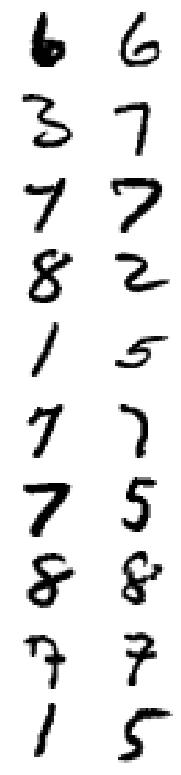

In [590]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [591]:
X_train2.shape

(5000, 784)

roughly half will be a pair of the same and half will be different

In [592]:
y_batch

array([[1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0]])

## 10.3

Exercise: train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not.

In [593]:
len(X_test)

10000

In [623]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

In [627]:
X_test1[453].shape

(2, 784)

In [628]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")
    
    

0 Train loss: 0.6891399
0 Test accuracy: 0.5279
1 Train loss: 0.5959447
2 Train loss: 0.5107754
3 Train loss: 0.48419416
4 Train loss: 0.47330052
5 Train loss: 0.41459125
5 Test accuracy: 0.8028
6 Train loss: 0.4419923
7 Train loss: 0.40510884
8 Train loss: 0.33301252
9 Train loss: 0.36144537
10 Train loss: 0.30094334
10 Test accuracy: 0.8597
11 Train loss: 0.32066968
12 Train loss: 0.24406616
13 Train loss: 0.2238958
14 Train loss: 0.21029705
15 Train loss: 0.20106173
15 Test accuracy: 0.9148
16 Train loss: 0.22492558
17 Train loss: 0.19936816
18 Train loss: 0.19617783
19 Train loss: 0.18172024
20 Train loss: 0.15426688
20 Test accuracy: 0.9311
21 Train loss: 0.17573786
22 Train loss: 0.1638955
23 Train loss: 0.15242475
24 Train loss: 0.17002347
25 Train loss: 0.12907042
25 Test accuracy: 0.9461
26 Train loss: 0.14714874
27 Train loss: 0.119652875
28 Train loss: 0.09090712
29 Train loss: 0.09782021
30 Train loss: 0.10042464
30 Test accuracy: 0.956
31 Train loss: 0.10888391
32 Train lo

In [615]:
X_test1.shape

(5139, 784)

we got 97.81%!

## 10.4 

create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class.

In [629]:
reset_graph()

n_inputs = 28*28
n_outputs = 10

#create handles
X = tf.placeholder(tf.float32, shape=(None, n_inputs),name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

dnn_outputs = dnn(X,name='DNN_A')
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(frozen_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [630]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9734
10 Test accuracy: 0.9753
20 Test accuracy: 0.9748
30 Test accuracy: 0.9744
40 Test accuracy: 0.9741
50 Test accuracy: 0.9748
60 Test accuracy: 0.9748
70 Test accuracy: 0.9746
80 Test accuracy: 0.9742
90 Test accuracy: 0.9745


review the last couple of ones later